<a href="https://colab.research.google.com/github/TAnbiR-638/new/blob/main/Msvan_RL_Combo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Upload Data and Install Libraries

# Step 1: Upload your solar_radiation.csv file
from google.colab import files
uploaded = files.upload()

# Verify upload
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

# (No specific libraries to install beyond standard Colab environment for this code)

Saving solar_radiation.csv to solar_radiation.csv
User uploaded file "solar_radiation.csv" with length 1407349 bytes


In [3]:
# Cell 2: Imports and Configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm # For progress bars in Colab
import math
import io # To read the uploaded file with pandas

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FILE_NAME = 'solar_radiation.csv' # Should match your uploaded file name

SEQ_LENGTH = 72  # Input sequence length (e.g., 6 hours of 5-min data)
PREDICTION_HORIZON = 288 # Output sequence length (24 hours * 12 samples/hour)
BATCH_SIZE = 32 # Adjust based on Colab's GPU memory (16 or 32 often work)
LEARNING_RATE = 1e-4
EPOCHS = 200      # Start with fewer epochs (e.g., 20-30) for faster Colab iterations
HIDDEN_SIZE_LSTM = 64
FDCNN_OUT_CHANNELS = 128
ATTENTION_UNITS = 128
DROPOUT_RATE = 0.2

print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Cell 3: Helper Functions

def create_sequences(data, seq_length, pred_horizon):
    xs, ys = [], []
    for i in range(len(data) - seq_length - pred_horizon + 1):
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length):(i + seq_length + pred_horizon)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

class SolarDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

def calculate_rmse(mse_loss):
    return math.sqrt(mse_loss)

In [5]:
# Cell 4: Model Components (FFC_block, Attention)

class FFC_block(nn.Module):
    def __init__(self, in_channels, out_channels_total, kernel_size=3, ratio_gin=0.5,
                 stride=1, padding="same", dilation=1, groups=1, bias=False): # Use padding="same"
        super(FFC_block, self).__init__()
        # Ensure out_channels_total is divisible by 2 for splitting
        if out_channels_total % 2 != 0:
            raise ValueError("out_channels_total must be divisible by 2 for FFC block splitting.")

        self.out_channels_part = out_channels_total // 2 # Output channels for local and global part EACH

        in_cg = int(in_channels * ratio_gin)
        in_cl = in_channels - in_cg
        self.ratio_gin = ratio_gin

        # Convolutions for the local path processing contributing to f_l
        self.conv_l2l = nn.Conv1d(in_cl, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)
        # Convolutions for the global path processing contributing to f_l
        self.conv_g2l = nn.Conv1d(in_cg, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)

        # Convolutions for the local path processing contributing to f_g
        self.conv_l2g = nn.Conv1d(in_cl, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)
        # Convolutions for the global path processing contributing to f_g (before FFT)
        self.conv_g2g_pre_fft = nn.Conv1d(in_cg, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)
        # Optional: A conv after IFFT for g2g path if needed, or directly use pre_fft output for FFT
        # self.conv_g2g_post_fft = nn.Conv1d(self.out_channels_part, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)


        self.relu = nn.ReLU(inplace=True)

    def forward(self, x): # x: (Batch, In_Channels, SeqLen)
        x_l, x_g = x[:, :int(x.size(1) * (1-self.ratio_gin))], x[:, int(x.size(1) * (1-self.ratio_gin)):]

        # Equation (11) logic: X_local_updated = X_local→local + X_global→local
        f_l_from_local = self.conv_l2l(x_l)
        f_l_from_global = self.conv_g2l(x_g)
        f_l = self.relu(f_l_from_local + f_l_from_global)

        # Equation (12) logic: X_global_updated = X_global→global + X_local→global
        f_g_from_local = self.conv_l2g(x_l)

        # Global path processing for f_g
        f_g_from_global_pre_fft = self.conv_g2g_pre_fft(x_g)

        # Apply FFT, then IFFT.
        # The "learnable" part in frequency domain is tricky.
        # A true FDCNN might have learnable complex weights or separate convolutions for real/imag parts.
        # Here, we simplify: conv -> fft -> (potential learnable scaling/filtering) -> ifft
        # For simplicity, let's assume the main "global" processing is the FFT/IFFT itself on convolved features.
        original_len = f_g_from_global_pre_fft.size(2)
        f_g_fft = torch.fft.rfft(f_g_from_global_pre_fft, dim=2)
        # (Potentially, insert learnable operations on f_g_fft here)
        f_g_ifft = torch.fft.irfft(f_g_fft, n=original_len, dim=2)
        # f_g_from_global = self.relu(self.conv_g2g_post_fft(f_g_ifft)) # If using post_fft conv
        f_g_from_global = f_g_ifft # Directly use ifft output if no post_fft conv

        f_g = self.relu(f_g_from_local + f_g_from_global)

        return torch.cat((f_l, f_g), dim=1) # Concatenate features from local and global updates

class Attention(nn.Module):
    def __init__(self, num_input_channels, seq_len_for_hi, attention_units):
        super(Attention, self).__init__()
        # Input to attention: (Batch, Num_FDCNN_Channels, SeqLen)
        # 'hi' is a channel vector of length 'seq_len_for_hi'.
        # Wh maps each 'hi' (a channel vector) to 'attention_units'.
        self.fc_for_aei = nn.Linear(seq_len_for_hi, attention_units) # W_h * h_i part
        self.Wh_att_score = nn.Linear(attention_units, 1) # To get a single score per channel for softmax

    def forward(self, x): # x: (Batch, Num_FDCNN_Channels, SeqLen)
        batch_size, num_fdcnn_channels, seq_len = x.shape

        ae_scores_list = []
        for i in range(num_fdcnn_channels):
            hi = x[:, i, :]  # (Batch, SeqLen) - this is one channel vector

            # Eq 13: aei = max(0, Whi hi + bh)
            # Assuming bh is absorbed or not explicitly used for simplicity like some attention heads
            aei_processed = self.fc_for_aei(hi) # (Batch, attention_units)
            aei_activated = torch.relu(aei_processed) # (Batch, attention_units)

            # Get a single score for this channel
            score_for_channel_i = self.Wh_att_score(aei_activated).squeeze(-1) # (Batch)
            ae_scores_list.append(score_for_channel_i)

        ae_T_scores = torch.stack(ae_scores_list, dim=1) # (Batch, Num_FDCNN_Channels)

        # Eq 14: ari = softmax(aei)
        ari_weights = torch.softmax(ae_T_scores, dim=1) # (Batch, Num_FDCNN_Channels)

        # Eq 15: asi = Σ arj hj
        # ari_weights: (Batch, Num_FDCNN_Channels)
        # x: (Batch, Num_FDCNN_Channels, SeqLen)
        # We need to expand ari_weights for element-wise multiplication
        # (Batch, Num_FDCNN_Channels, 1) * (Batch, Num_FDCNN_Channels, SeqLen)
        context_vector = torch.sum(ari_weights.unsqueeze(-1) * x, dim=1) # (Batch, SeqLen)

        return context_vector, ari_weights

In [6]:
# Cell 5: MSMVAN_Univariate Model Definition

class MSMVAN_Univariate(nn.Module):
    def __init__(self, input_size, hidden_size_lstm, lstm_layers, ffc_out_channels_total,
                 attention_units, pred_horizon, seq_len, dropout_rate=0.2):
        super(MSMVAN_Univariate, self).__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size, hidden_size_lstm, num_layers=lstm_layers,
                            batch_first=True, bidirectional=True,
                            dropout=dropout_rate if lstm_layers > 1 else 0)

        bilstm_out_features = hidden_size_lstm * 2

        # FFC block input channels = bilstm_out_features
        # FFC block output channels = ffc_out_channels_total
        self.ffc1 = FFC_block(bilstm_out_features, ffc_out_channels_total, kernel_size=3, padding="same")
        # self.ffc2 = FFC_block(ffc_out_channels_total, ffc_out_channels_total, kernel_size=3, padding="same") # Optional

        # Attention input: (Batch, ffc_out_channels_total, SeqLen)
        # 'hi' for attention is a channel vector of length SeqLen
        self.attention = Attention(
            num_input_channels=ffc_out_channels_total, # Number of channels from FFC
            seq_len_for_hi=seq_len, # Length of each channel vector
            attention_units=attention_units
        )

        self.dropout = nn.Dropout(dropout_rate)
        # Input to fc is attention output (Batch, SeqLen)
        self.fc = nn.Linear(seq_len, pred_horizon)

    def forward(self, x): # x: (Batch, SeqLen, Input_Size=1 for univariate)
        lstm_out, _ = self.lstm(x) # (Batch, SeqLen, Hidden*2)

        # Prepare for FFC: (Batch, Channels=Hidden*2, SeqLen)
        ffc_in = lstm_out.permute(0, 2, 1)

        ffc_out = self.ffc1(ffc_in)
        # ffc_out = self.ffc2(ffc_out) # If using second FFC

        # ffc_out is (Batch, ffc_out_channels_total, SeqLen)
        attn_out_context_vector, attn_weights = self.attention(ffc_out) # attn_out_context_vector: (Batch, SeqLen)

        dropped_out = self.dropout(attn_out_context_vector)
        predictions = self.fc(dropped_out) # (Batch, PredHorizon)
        return predictions

In [7]:
# Cell 6: Data Loading and Preprocessing

# Read the uploaded file
try:
    df = pd.read_csv(io.BytesIO(uploaded[FILE_NAME]), usecols=['Solar_Radiation'])
    print(f"Successfully loaded {FILE_NAME}")
except KeyError:
    print(f"Error: File '{FILE_NAME}' not found in upload or 'Solar_Radiation' column missing.")
    # Fallback to dummy data if file loading fails, for testing the rest of the script
    print("Generating dummy data as fallback.")
    data_raw = np.sin(np.linspace(0, 1000, 33133)) * 50 + 50
    data_raw += np.random.normal(0, 5, 33133)
    data_raw = np.clip(data_raw, 0, None)
else:
    # Ensure 'Solar_Radiation' is numeric. If already numeric, this won't harm.
    df['Solar_Radiation'] = pd.to_numeric(df['Solar_Radiation'], errors='coerce')
    # The problem states "no null value", but this is good practice.
    # If coerce creates NaNs for some reason, drop them.
    df.dropna(subset=['Solar_Radiation'], inplace=True)
    data_raw = df['Solar_Radiation'].values.astype(float)

if len(data_raw) < SEQ_LENGTH + PREDICTION_HORIZON:
    raise ValueError(f"Not enough data points ({len(data_raw)}) for the given SEQ_LENGTH ({SEQ_LENGTH}) and PREDICTION_HORIZON ({PREDICTION_HORIZON}).")

print(f"Raw data shape: {data_raw.shape}")

scaler = MinMaxScaler(feature_range=(-1, 1)) # Or (0,1) if solar radiation is always non-negative
data_scaled = scaler.fit_transform(data_raw.reshape(-1, 1))

features, targets = create_sequences(data_scaled, SEQ_LENGTH, PREDICTION_HORIZON)
features = features.reshape(features.shape[0], SEQ_LENGTH, 1) # Add feature dim for univariate

print(f"Features shape: {features.shape}, Targets shape: {targets.shape}")

# Split data (e.g., 80% train, 10% val, 10% test)
# Ensure enough samples for each split after sequence creation
if len(features) < 10: # Arbitrary small number, adjust if needed
    raise ValueError(f"Too few sequences ({len(features)}) created. Check data length, SEQ_LENGTH, and PREDICTION_HORIZON.")

train_ratio = 0.8
val_ratio = 0.1
# test_ratio = 0.1 # Implicit

train_size = int(len(features) * train_ratio)
val_size = int(len(features) * val_ratio)
# test_size = len(features) - train_size - val_size # The rest is test

train_features, train_targets = features[:train_size], targets[:train_size]
val_features, val_targets = features[train_size:train_size+val_size], targets[train_size:train_size+val_size]
test_features, test_targets = features[train_size+val_size:], targets[train_size+val_size:]

print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")


# Create DataLoaders
if len(train_features) > 0:
    train_dataset = SolarDataset(train_features, train_targets)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
else:
    train_loader = None
    print("Warning: Training set is empty after splitting.")

if len(val_features) > 0:
    val_dataset = SolarDataset(val_features, val_targets)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
else:
    val_loader = None
    print("Warning: Validation set is empty after splitting.")

if len(test_features) > 0:
    test_dataset = SolarDataset(test_features, test_targets)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
else:
    test_loader = None
    print("Warning: Test set is empty after splitting.")


if not train_loader:
    raise ValueError("Training DataLoader could not be created. Check data and split sizes.")

Successfully loaded solar_radiation.csv
Raw data shape: (33133,)
Features shape: (32774, 72, 1), Targets shape: (32774, 288, 1)
Train features shape: (26219, 72, 1)
Validation features shape: (3277, 72, 1)
Test features shape: (3278, 72, 1)


In [8]:
# Cell 7: Model Initialization, Optimizer, Criterion, Scheduler

model = MSMVAN_Univariate(
    input_size=1, # Univariate
    hidden_size_lstm=HIDDEN_SIZE_LSTM,
    lstm_layers=2, # Example, can be tuned
    ffc_out_channels_total=FDCNN_OUT_CHANNELS,
    attention_units=ATTENTION_UNITS,
    pred_horizon=PREDICTION_HORIZON,
    seq_len=SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE
).to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True) # Reduced patience

print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

MSMVAN_Univariate(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (ffc1): FFC_block(
    (conv_l2l): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (conv_g2l): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (conv_l2g): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (conv_g2g_pre_fft): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (relu): ReLU(inplace=True)
  )
  (attention): Attention(
    (fc_for_aei): Linear(in_features=72, out_features=128, bias=True)
    (Wh_att_score): Linear(in_features=128, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=72, out_features=288, bias=True)
)
Total trainable parameters: 213281


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 58.48batch/s, MAE=0.293, MSE=0.107]



Epoch 1/200 Summary:
  LR: 0.000100
  Train MSE: 0.241543, RMSE: 0.491470, MAE: 0.403627
  Val   MSE: 0.138409, RMSE: 0.372034, MAE: 0.335300
  >>> New best validation MSE: 0.138409. Model saved. <<<
--------------------------------------------------


Epoch 2/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 58.35batch/s, MAE=0.287, MSE=0.104]



Epoch 2/200 Summary:
  LR: 0.000100
  Train MSE: 0.179731, RMSE: 0.423947, MAE: 0.352063
  Val   MSE: 0.136720, RMSE: 0.369757, MAE: 0.330816
  >>> New best validation MSE: 0.136720. Model saved. <<<
--------------------------------------------------


Epoch 3/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.67batch/s, MAE=0.268, MSE=0.106]



Epoch 3/200 Summary:
  LR: 0.000100
  Train MSE: 0.161305, RMSE: 0.401628, MAE: 0.327831
  Val   MSE: 0.088416, RMSE: 0.297348, MAE: 0.241190
  >>> New best validation MSE: 0.088416. Model saved. <<<
--------------------------------------------------


Epoch 4/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.93batch/s, MAE=0.257, MSE=0.105]



Epoch 4/200 Summary:
  LR: 0.000100
  Train MSE: 0.100964, RMSE: 0.317749, MAE: 0.246567
  Val   MSE: 0.073201, RMSE: 0.270556, MAE: 0.207715
  >>> New best validation MSE: 0.073201. Model saved. <<<
--------------------------------------------------


Epoch 5/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 58.03batch/s, MAE=0.222, MSE=0.0896]



Epoch 5/200 Summary:
  LR: 0.000100
  Train MSE: 0.088605, RMSE: 0.297665, MAE: 0.228287
  Val   MSE: 0.065023, RMSE: 0.254995, MAE: 0.182894
  >>> New best validation MSE: 0.065023. Model saved. <<<
--------------------------------------------------


Epoch 6/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.43batch/s, MAE=0.256, MSE=0.124]



Epoch 6/200 Summary:
  LR: 0.000100
  Train MSE: 0.082148, RMSE: 0.286615, MAE: 0.215612
  Val   MSE: 0.068328, RMSE: 0.261397, MAE: 0.183179
--------------------------------------------------


Epoch 7/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 58.90batch/s, MAE=0.179, MSE=0.0707]



Epoch 7/200 Summary:
  LR: 0.000100
  Train MSE: 0.078116, RMSE: 0.279493, MAE: 0.207501
  Val   MSE: 0.061466, RMSE: 0.247923, MAE: 0.167540
  >>> New best validation MSE: 0.061466. Model saved. <<<
--------------------------------------------------


Epoch 8/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 58.44batch/s, MAE=0.193, MSE=0.0835]



Epoch 8/200 Summary:
  LR: 0.000100
  Train MSE: 0.075236, RMSE: 0.274293, MAE: 0.201582
  Val   MSE: 0.055796, RMSE: 0.236212, MAE: 0.157049
  >>> New best validation MSE: 0.055796. Model saved. <<<
--------------------------------------------------


Epoch 9/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 58.90batch/s, MAE=0.211, MSE=0.101]



Epoch 9/200 Summary:
  LR: 0.000100
  Train MSE: 0.073558, RMSE: 0.271216, MAE: 0.197892
  Val   MSE: 0.058368, RMSE: 0.241594, MAE: 0.155490
--------------------------------------------------


Epoch 10/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 47.68batch/s, MAE=0.19, MSE=0.0847]



Epoch 10/200 Summary:
  LR: 0.000100
  Train MSE: 0.071688, RMSE: 0.267745, MAE: 0.193893
  Val   MSE: 0.057360, RMSE: 0.239499, MAE: 0.156666
--------------------------------------------------


Epoch 11/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 41.95batch/s, MAE=0.186, MSE=0.0751]



Epoch 11/200 Summary:
  LR: 0.000100
  Train MSE: 0.070399, RMSE: 0.265328, MAE: 0.190866
  Val   MSE: 0.059760, RMSE: 0.244458, MAE: 0.161155
--------------------------------------------------


Epoch 12/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 47.53batch/s, MAE=0.216, MSE=0.0953]



Epoch 12/200 Summary:
  LR: 0.000100
  Train MSE: 0.069343, RMSE: 0.263330, MAE: 0.188494
  Val   MSE: 0.060734, RMSE: 0.246443, MAE: 0.163152
--------------------------------------------------


Epoch 13/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.81batch/s, MAE=0.192, MSE=0.0879]



Epoch 13/200 Summary:
  LR: 0.000050
  Train MSE: 0.068713, RMSE: 0.262131, MAE: 0.186658
  Val   MSE: 0.054301, RMSE: 0.233027, MAE: 0.147685
  >>> New best validation MSE: 0.054301. Model saved. <<<
--------------------------------------------------


Epoch 14/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 58.47batch/s, MAE=0.199, MSE=0.0889]



Epoch 14/200 Summary:
  LR: 0.000050
  Train MSE: 0.066173, RMSE: 0.257240, MAE: 0.182983
  Val   MSE: 0.056585, RMSE: 0.237875, MAE: 0.150634
--------------------------------------------------


Epoch 15/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.69batch/s, MAE=0.211, MSE=0.0954]



Epoch 15/200 Summary:
  LR: 0.000050
  Train MSE: 0.066832, RMSE: 0.258520, MAE: 0.183436
  Val   MSE: 0.055777, RMSE: 0.236171, MAE: 0.151720
--------------------------------------------------


Epoch 16/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.44batch/s, MAE=0.18, MSE=0.0795]



Epoch 16/200 Summary:
  LR: 0.000050
  Train MSE: 0.066621, RMSE: 0.258110, MAE: 0.182847
  Val   MSE: 0.051982, RMSE: 0.227995, MAE: 0.145033
  >>> New best validation MSE: 0.051982. Model saved. <<<
--------------------------------------------------


Epoch 17/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.68batch/s, MAE=0.181, MSE=0.0781]



Epoch 17/200 Summary:
  LR: 0.000050
  Train MSE: 0.065806, RMSE: 0.256526, MAE: 0.181963
  Val   MSE: 0.057446, RMSE: 0.239678, MAE: 0.148017
--------------------------------------------------


Epoch 18/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.39batch/s, MAE=0.189, MSE=0.0843]



Epoch 18/200 Summary:
  LR: 0.000050
  Train MSE: 0.065778, RMSE: 0.256472, MAE: 0.181419
  Val   MSE: 0.053967, RMSE: 0.232307, MAE: 0.148621
--------------------------------------------------


Epoch 19/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.99batch/s, MAE=0.191, MSE=0.0866]



Epoch 19/200 Summary:
  LR: 0.000050
  Train MSE: 0.064761, RMSE: 0.254482, MAE: 0.179754
  Val   MSE: 0.054284, RMSE: 0.232988, MAE: 0.144848
--------------------------------------------------


Epoch 20/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.07batch/s, MAE=0.213, MSE=0.103]



Epoch 20/200 Summary:
  LR: 0.000050
  Train MSE: 0.066417, RMSE: 0.257714, MAE: 0.180401
  Val   MSE: 0.057728, RMSE: 0.240267, MAE: 0.149731
--------------------------------------------------


Epoch 21/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.80batch/s, MAE=0.181, MSE=0.0806]



Epoch 21/200 Summary:
  LR: 0.000025
  Train MSE: 0.062561, RMSE: 0.250123, MAE: 0.176486
  Val   MSE: 0.051569, RMSE: 0.227087, MAE: 0.139415
  >>> New best validation MSE: 0.051569. Model saved. <<<
--------------------------------------------------


Epoch 22/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 58.07batch/s, MAE=0.182, MSE=0.0803]



Epoch 22/200 Summary:
  LR: 0.000025
  Train MSE: 0.063282, RMSE: 0.251560, MAE: 0.177013
  Val   MSE: 0.051650, RMSE: 0.227266, MAE: 0.142328
--------------------------------------------------


Epoch 23/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.93batch/s, MAE=0.198, MSE=0.0919]



Epoch 23/200 Summary:
  LR: 0.000025
  Train MSE: 0.062619, RMSE: 0.250239, MAE: 0.176107
  Val   MSE: 0.054139, RMSE: 0.232678, MAE: 0.145024
--------------------------------------------------


Epoch 24/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.53batch/s, MAE=0.187, MSE=0.0841]



Epoch 24/200 Summary:
  LR: 0.000025
  Train MSE: 0.062256, RMSE: 0.249512, MAE: 0.175631
  Val   MSE: 0.052874, RMSE: 0.229944, MAE: 0.143112
--------------------------------------------------


Epoch 25/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.55batch/s, MAE=0.181, MSE=0.0796]



Epoch 25/200 Summary:
  LR: 0.000025
  Train MSE: 0.062031, RMSE: 0.249060, MAE: 0.175157
  Val   MSE: 0.053834, RMSE: 0.232022, MAE: 0.144956
--------------------------------------------------


Epoch 26/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.53batch/s, MAE=0.175, MSE=0.0761]



Epoch 26/200 Summary:
  LR: 0.000013
  Train MSE: 0.061154, RMSE: 0.247293, MAE: 0.173852
  Val   MSE: 0.051678, RMSE: 0.227328, MAE: 0.139750
--------------------------------------------------


Epoch 27/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.20batch/s, MAE=0.183, MSE=0.0826]



Epoch 27/200 Summary:
  LR: 0.000013
  Train MSE: 0.061158, RMSE: 0.247302, MAE: 0.173577
  Val   MSE: 0.052333, RMSE: 0.228763, MAE: 0.140129
--------------------------------------------------


Epoch 28/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 45.99batch/s, MAE=0.184, MSE=0.0816]



Epoch 28/200 Summary:
  LR: 0.000013
  Train MSE: 0.061032, RMSE: 0.247047, MAE: 0.173632
  Val   MSE: 0.051077, RMSE: 0.226002, MAE: 0.143673
  >>> New best validation MSE: 0.051077. Model saved. <<<
--------------------------------------------------


Epoch 29/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 42.28batch/s, MAE=0.184, MSE=0.084]



Epoch 29/200 Summary:
  LR: 0.000013
  Train MSE: 0.060633, RMSE: 0.246238, MAE: 0.172820
  Val   MSE: 0.051100, RMSE: 0.226053, MAE: 0.139608
--------------------------------------------------


Epoch 30/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 41.78batch/s, MAE=0.179, MSE=0.0808]



Epoch 30/200 Summary:
  LR: 0.000013
  Train MSE: 0.060914, RMSE: 0.246808, MAE: 0.173101
  Val   MSE: 0.051346, RMSE: 0.226596, MAE: 0.137629
--------------------------------------------------


Epoch 31/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 42.51batch/s, MAE=0.201, MSE=0.0966]



Epoch 31/200 Summary:
  LR: 0.000013
  Train MSE: 0.060550, RMSE: 0.246069, MAE: 0.172713
  Val   MSE: 0.055878, RMSE: 0.236386, MAE: 0.144696
--------------------------------------------------


Epoch 32/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 41.03batch/s, MAE=0.176, MSE=0.0765]



Epoch 32/200 Summary:
  LR: 0.000013
  Train MSE: 0.060693, RMSE: 0.246359, MAE: 0.172699
  Val   MSE: 0.055771, RMSE: 0.236159, MAE: 0.145912
--------------------------------------------------


Epoch 33/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 42.92batch/s, MAE=0.169, MSE=0.074]



Epoch 33/200 Summary:
  LR: 0.000006
  Train MSE: 0.059885, RMSE: 0.244714, MAE: 0.171840
  Val   MSE: 0.054069, RMSE: 0.232527, MAE: 0.141799
--------------------------------------------------


Epoch 34/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 46.11batch/s, MAE=0.179, MSE=0.0809]



Epoch 34/200 Summary:
  LR: 0.000006
  Train MSE: 0.059661, RMSE: 0.244255, MAE: 0.171434
  Val   MSE: 0.050647, RMSE: 0.225049, MAE: 0.136586
  >>> New best validation MSE: 0.050647. Model saved. <<<
--------------------------------------------------


Epoch 35/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 48.51batch/s, MAE=0.177, MSE=0.0797]



Epoch 35/200 Summary:
  LR: 0.000006
  Train MSE: 0.059789, RMSE: 0.244519, MAE: 0.171344
  Val   MSE: 0.050351, RMSE: 0.224389, MAE: 0.136549
  >>> New best validation MSE: 0.050351. Model saved. <<<
--------------------------------------------------


Epoch 36/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.83batch/s, MAE=0.175, MSE=0.0779]



Epoch 36/200 Summary:
  LR: 0.000006
  Train MSE: 0.059535, RMSE: 0.243998, MAE: 0.171075
  Val   MSE: 0.054862, RMSE: 0.234227, MAE: 0.142086
--------------------------------------------------


Epoch 37/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.87batch/s, MAE=0.176, MSE=0.0784]



Epoch 37/200 Summary:
  LR: 0.000006
  Train MSE: 0.059856, RMSE: 0.244655, MAE: 0.171568
  Val   MSE: 0.050534, RMSE: 0.224799, MAE: 0.135573
--------------------------------------------------


Epoch 38/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.06batch/s, MAE=0.178, MSE=0.0798]



Epoch 38/200 Summary:
  LR: 0.000006
  Train MSE: 0.059794, RMSE: 0.244528, MAE: 0.171474
  Val   MSE: 0.052052, RMSE: 0.228149, MAE: 0.139401
--------------------------------------------------


Epoch 39/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.17batch/s, MAE=0.172, MSE=0.0748]



Epoch 39/200 Summary:
  LR: 0.000006
  Train MSE: 0.059589, RMSE: 0.244109, MAE: 0.170836
  Val   MSE: 0.051220, RMSE: 0.226319, MAE: 0.138051
--------------------------------------------------


Epoch 40/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.93batch/s, MAE=0.174, MSE=0.0776]



Epoch 40/200 Summary:
  LR: 0.000003
  Train MSE: 0.059354, RMSE: 0.243627, MAE: 0.170943
  Val   MSE: 0.051435, RMSE: 0.226793, MAE: 0.137617
--------------------------------------------------


Epoch 41/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.14batch/s, MAE=0.176, MSE=0.0794]



Epoch 41/200 Summary:
  LR: 0.000003
  Train MSE: 0.059253, RMSE: 0.243418, MAE: 0.170961
  Val   MSE: 0.050146, RMSE: 0.223934, MAE: 0.135392
  >>> New best validation MSE: 0.050146. Model saved. <<<
--------------------------------------------------


Epoch 42/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.08batch/s, MAE=0.174, MSE=0.0778]



Epoch 42/200 Summary:
  LR: 0.000003
  Train MSE: 0.058939, RMSE: 0.242773, MAE: 0.170318
  Val   MSE: 0.050076, RMSE: 0.223776, MAE: 0.136737
  >>> New best validation MSE: 0.050076. Model saved. <<<
--------------------------------------------------


Epoch 43/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.35batch/s, MAE=0.181, MSE=0.0827]



Epoch 43/200 Summary:
  LR: 0.000003
  Train MSE: 0.059241, RMSE: 0.243395, MAE: 0.170675
  Val   MSE: 0.050938, RMSE: 0.225695, MAE: 0.137102
--------------------------------------------------


Epoch 44/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.93batch/s, MAE=0.178, MSE=0.0808]



Epoch 44/200 Summary:
  LR: 0.000003
  Train MSE: 0.058876, RMSE: 0.242645, MAE: 0.170108
  Val   MSE: 0.050329, RMSE: 0.224341, MAE: 0.137212
--------------------------------------------------


Epoch 45/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.20batch/s, MAE=0.171, MSE=0.0752]



Epoch 45/200 Summary:
  LR: 0.000003
  Train MSE: 0.058954, RMSE: 0.242805, MAE: 0.170250
  Val   MSE: 0.049601, RMSE: 0.222713, MAE: 0.136134
  >>> New best validation MSE: 0.049601. Model saved. <<<
--------------------------------------------------


Epoch 46/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.38batch/s, MAE=0.174, MSE=0.0779]



Epoch 46/200 Summary:
  LR: 0.000003
  Train MSE: 0.059073, RMSE: 0.243049, MAE: 0.170444
  Val   MSE: 0.050412, RMSE: 0.224527, MAE: 0.137398
--------------------------------------------------


Epoch 47/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 57.02batch/s, MAE=0.176, MSE=0.0797]



Epoch 47/200 Summary:
  LR: 0.000003
  Train MSE: 0.058881, RMSE: 0.242654, MAE: 0.170056
  Val   MSE: 0.050531, RMSE: 0.224792, MAE: 0.135136
--------------------------------------------------


Epoch 48/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.31batch/s, MAE=0.179, MSE=0.0807]



Epoch 48/200 Summary:
  LR: 0.000003
  Train MSE: 0.059170, RMSE: 0.243248, MAE: 0.170728
  Val   MSE: 0.054206, RMSE: 0.232822, MAE: 0.141552
--------------------------------------------------


Epoch 49/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.53batch/s, MAE=0.175, MSE=0.0782]



Epoch 49/200 Summary:
  LR: 0.000003
  Train MSE: 0.059000, RMSE: 0.242900, MAE: 0.170321
  Val   MSE: 0.049927, RMSE: 0.223444, MAE: 0.135851
--------------------------------------------------


Epoch 50/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.68batch/s, MAE=0.173, MSE=0.0767]



Epoch 50/200 Summary:
  LR: 0.000002
  Train MSE: 0.058845, RMSE: 0.242581, MAE: 0.170295
  Val   MSE: 0.049873, RMSE: 0.223322, MAE: 0.135717
--------------------------------------------------


Epoch 51/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.87batch/s, MAE=0.175, MSE=0.0777]



Epoch 51/200 Summary:
  LR: 0.000002
  Train MSE: 0.058830, RMSE: 0.242548, MAE: 0.170086
  Val   MSE: 0.050367, RMSE: 0.224427, MAE: 0.137373
--------------------------------------------------


Epoch 52/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.08batch/s, MAE=0.175, MSE=0.0783]



Epoch 52/200 Summary:
  LR: 0.000002
  Train MSE: 0.058374, RMSE: 0.241608, MAE: 0.169511
  Val   MSE: 0.050419, RMSE: 0.224542, MAE: 0.136331
--------------------------------------------------


Epoch 53/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.27batch/s, MAE=0.176, MSE=0.0793]



Epoch 53/200 Summary:
  LR: 0.000002
  Train MSE: 0.058554, RMSE: 0.241979, MAE: 0.169795
  Val   MSE: 0.050190, RMSE: 0.224030, MAE: 0.135265
--------------------------------------------------


Epoch 54/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.28batch/s, MAE=0.174, MSE=0.0777]



Epoch 54/200 Summary:
  LR: 0.000001
  Train MSE: 0.058525, RMSE: 0.241918, MAE: 0.169792
  Val   MSE: 0.050464, RMSE: 0.224641, MAE: 0.136970
--------------------------------------------------


Epoch 55/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.21batch/s, MAE=0.172, MSE=0.0767]



Epoch 55/200 Summary:
  LR: 0.000001
  Train MSE: 0.058470, RMSE: 0.241807, MAE: 0.169604
  Val   MSE: 0.050549, RMSE: 0.224832, MAE: 0.136436
--------------------------------------------------


Epoch 56/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.81batch/s, MAE=0.172, MSE=0.0768]



Epoch 56/200 Summary:
  LR: 0.000001
  Train MSE: 0.058321, RMSE: 0.241498, MAE: 0.169376
  Val   MSE: 0.050042, RMSE: 0.223701, MAE: 0.135715
--------------------------------------------------


Epoch 57/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.31batch/s, MAE=0.175, MSE=0.0791]



Epoch 57/200 Summary:
  LR: 0.000001
  Train MSE: 0.058259, RMSE: 0.241369, MAE: 0.169153
  Val   MSE: 0.049894, RMSE: 0.223369, MAE: 0.135634
--------------------------------------------------


Epoch 58/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.63batch/s, MAE=0.174, MSE=0.0783]



Epoch 58/200 Summary:
  LR: 0.000000
  Train MSE: 0.058513, RMSE: 0.241895, MAE: 0.169711
  Val   MSE: 0.050076, RMSE: 0.223778, MAE: 0.136080
--------------------------------------------------


Epoch 59/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.74batch/s, MAE=0.174, MSE=0.0779]



Epoch 59/200 Summary:
  LR: 0.000000
  Train MSE: 0.058296, RMSE: 0.241446, MAE: 0.169145
  Val   MSE: 0.049978, RMSE: 0.223557, MAE: 0.135616
--------------------------------------------------


Epoch 60/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.97batch/s, MAE=0.175, MSE=0.0788]



Epoch 60/200 Summary:
  LR: 0.000000
  Train MSE: 0.058381, RMSE: 0.241621, MAE: 0.169345
  Val   MSE: 0.050163, RMSE: 0.223972, MAE: 0.136493
--------------------------------------------------


Epoch 61/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.09batch/s, MAE=0.174, MSE=0.0781]



Epoch 61/200 Summary:
  LR: 0.000000
  Train MSE: 0.058424, RMSE: 0.241712, MAE: 0.169739
  Val   MSE: 0.049881, RMSE: 0.223341, MAE: 0.135595
--------------------------------------------------


Epoch 62/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.76batch/s, MAE=0.175, MSE=0.0785]



Epoch 62/200 Summary:
  LR: 0.000000
  Train MSE: 0.058205, RMSE: 0.241257, MAE: 0.169192
  Val   MSE: 0.049872, RMSE: 0.223321, MAE: 0.135848
--------------------------------------------------


Epoch 63/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.85batch/s, MAE=0.173, MSE=0.0777]



Epoch 63/200 Summary:
  LR: 0.000000
  Train MSE: 0.058170, RMSE: 0.241184, MAE: 0.169188
  Val   MSE: 0.049828, RMSE: 0.223221, MAE: 0.135863
--------------------------------------------------


Epoch 64/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.02batch/s, MAE=0.173, MSE=0.0775]



Epoch 64/200 Summary:
  LR: 0.000000
  Train MSE: 0.058228, RMSE: 0.241305, MAE: 0.169446
  Val   MSE: 0.049968, RMSE: 0.223534, MAE: 0.136193
--------------------------------------------------


Epoch 65/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.38batch/s, MAE=0.173, MSE=0.0773]



Epoch 65/200 Summary:
  LR: 0.000000
  Train MSE: 0.058340, RMSE: 0.241537, MAE: 0.169450
  Val   MSE: 0.050151, RMSE: 0.223944, MAE: 0.136061
--------------------------------------------------


Epoch 66/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.23batch/s, MAE=0.173, MSE=0.0777]



Epoch 66/200 Summary:
  LR: 0.000000
  Train MSE: 0.058534, RMSE: 0.241939, MAE: 0.169859
  Val   MSE: 0.049936, RMSE: 0.223463, MAE: 0.135766
--------------------------------------------------


Epoch 67/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.67batch/s, MAE=0.173, MSE=0.0774]



Epoch 67/200 Summary:
  LR: 0.000000
  Train MSE: 0.058251, RMSE: 0.241352, MAE: 0.168986
  Val   MSE: 0.049951, RMSE: 0.223497, MAE: 0.135632
--------------------------------------------------


Epoch 68/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.24batch/s, MAE=0.172, MSE=0.0771]



Epoch 68/200 Summary:
  LR: 0.000000
  Train MSE: 0.058254, RMSE: 0.241358, MAE: 0.169375
  Val   MSE: 0.049930, RMSE: 0.223449, MAE: 0.135608
--------------------------------------------------


Epoch 69/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.37batch/s, MAE=0.174, MSE=0.0781]



Epoch 69/200 Summary:
  LR: 0.000000
  Train MSE: 0.058277, RMSE: 0.241406, MAE: 0.169220
  Val   MSE: 0.049769, RMSE: 0.223089, MAE: 0.135417
--------------------------------------------------


Epoch 70/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.04batch/s, MAE=0.174, MSE=0.0781]



Epoch 70/200 Summary:
  LR: 0.000000
  Train MSE: 0.058219, RMSE: 0.241285, MAE: 0.169231
  Val   MSE: 0.049774, RMSE: 0.223101, MAE: 0.135363
--------------------------------------------------


Epoch 71/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.63batch/s, MAE=0.173, MSE=0.0778]



Epoch 71/200 Summary:
  LR: 0.000000
  Train MSE: 0.058181, RMSE: 0.241207, MAE: 0.169144
  Val   MSE: 0.049802, RMSE: 0.223163, MAE: 0.135552
--------------------------------------------------


Epoch 72/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.70batch/s, MAE=0.173, MSE=0.0775]



Epoch 72/200 Summary:
  LR: 0.000000
  Train MSE: 0.058233, RMSE: 0.241315, MAE: 0.169178
  Val   MSE: 0.049858, RMSE: 0.223289, MAE: 0.135559
--------------------------------------------------


Epoch 73/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 46.67batch/s, MAE=0.173, MSE=0.0773]



Epoch 73/200 Summary:
  LR: 0.000000
  Train MSE: 0.058251, RMSE: 0.241353, MAE: 0.169120
  Val   MSE: 0.049871, RMSE: 0.223319, MAE: 0.135510
--------------------------------------------------


Epoch 74/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 40.65batch/s, MAE=0.173, MSE=0.0775]



Epoch 74/200 Summary:
  LR: 0.000000
  Train MSE: 0.058252, RMSE: 0.241354, MAE: 0.169319
  Val   MSE: 0.049826, RMSE: 0.223218, MAE: 0.135529
--------------------------------------------------


Epoch 75/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 50.22batch/s, MAE=0.173, MSE=0.0775]



Epoch 75/200 Summary:
  LR: 0.000000
  Train MSE: 0.058307, RMSE: 0.241469, MAE: 0.169407
  Val   MSE: 0.049829, RMSE: 0.223224, MAE: 0.135542
--------------------------------------------------


Epoch 76/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.71batch/s, MAE=0.173, MSE=0.0775]



Epoch 76/200 Summary:
  LR: 0.000000
  Train MSE: 0.058279, RMSE: 0.241410, MAE: 0.169351
  Val   MSE: 0.049856, RMSE: 0.223284, MAE: 0.135585
--------------------------------------------------


Epoch 77/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.64batch/s, MAE=0.173, MSE=0.0776]



Epoch 77/200 Summary:
  LR: 0.000000
  Train MSE: 0.058313, RMSE: 0.241480, MAE: 0.169493
  Val   MSE: 0.049835, RMSE: 0.223238, MAE: 0.135555
--------------------------------------------------


Epoch 78/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 49.95batch/s, MAE=0.173, MSE=0.0776]



Epoch 78/200 Summary:
  LR: 0.000000
  Train MSE: 0.058324, RMSE: 0.241503, MAE: 0.169575
  Val   MSE: 0.049833, RMSE: 0.223232, MAE: 0.135544
--------------------------------------------------


Epoch 79/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.41batch/s, MAE=0.173, MSE=0.0775]



Epoch 79/200 Summary:
  LR: 0.000000
  Train MSE: 0.058106, RMSE: 0.241052, MAE: 0.168929
  Val   MSE: 0.049857, RMSE: 0.223287, MAE: 0.135543
--------------------------------------------------


Epoch 80/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.10batch/s, MAE=0.173, MSE=0.0777]



Epoch 80/200 Summary:
  LR: 0.000000
  Train MSE: 0.058302, RMSE: 0.241457, MAE: 0.169436
  Val   MSE: 0.049803, RMSE: 0.223166, MAE: 0.135538
--------------------------------------------------


Epoch 81/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.11batch/s, MAE=0.173, MSE=0.0775]



Epoch 81/200 Summary:
  LR: 0.000000
  Train MSE: 0.058094, RMSE: 0.241028, MAE: 0.169067
  Val   MSE: 0.049863, RMSE: 0.223300, MAE: 0.135569
--------------------------------------------------


Epoch 82/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.33batch/s, MAE=0.173, MSE=0.0775]



Epoch 82/200 Summary:
  LR: 0.000000
  Train MSE: 0.058275, RMSE: 0.241403, MAE: 0.169399
  Val   MSE: 0.049869, RMSE: 0.223314, MAE: 0.135560
--------------------------------------------------


Epoch 83/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.88batch/s, MAE=0.173, MSE=0.0776]



Epoch 83/200 Summary:
  LR: 0.000000
  Train MSE: 0.058368, RMSE: 0.241595, MAE: 0.169382
  Val   MSE: 0.049855, RMSE: 0.223283, MAE: 0.135588
--------------------------------------------------


Epoch 84/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.28batch/s, MAE=0.173, MSE=0.0774]



Epoch 84/200 Summary:
  LR: 0.000000
  Train MSE: 0.058207, RMSE: 0.241262, MAE: 0.169164
  Val   MSE: 0.049906, RMSE: 0.223397, MAE: 0.135616
--------------------------------------------------


Epoch 85/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.50batch/s, MAE=0.173, MSE=0.0777]



Epoch 85/200 Summary:
  LR: 0.000000
  Train MSE: 0.058256, RMSE: 0.241363, MAE: 0.169305
  Val   MSE: 0.049846, RMSE: 0.223261, MAE: 0.135597
--------------------------------------------------


Epoch 86/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.40batch/s, MAE=0.173, MSE=0.0775]



Epoch 86/200 Summary:
  LR: 0.000000
  Train MSE: 0.058143, RMSE: 0.241129, MAE: 0.169227
  Val   MSE: 0.049862, RMSE: 0.223299, MAE: 0.135593
--------------------------------------------------


Epoch 87/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.51batch/s, MAE=0.173, MSE=0.0775]



Epoch 87/200 Summary:
  LR: 0.000000
  Train MSE: 0.058189, RMSE: 0.241224, MAE: 0.169110
  Val   MSE: 0.049854, RMSE: 0.223280, MAE: 0.135594
--------------------------------------------------


Epoch 88/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.96batch/s, MAE=0.173, MSE=0.0775]



Epoch 88/200 Summary:
  LR: 0.000000
  Train MSE: 0.058213, RMSE: 0.241274, MAE: 0.169280
  Val   MSE: 0.049873, RMSE: 0.223323, MAE: 0.135619
--------------------------------------------------


Epoch 89/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.77batch/s, MAE=0.173, MSE=0.0775]



Epoch 89/200 Summary:
  LR: 0.000000
  Train MSE: 0.058142, RMSE: 0.241126, MAE: 0.169035
  Val   MSE: 0.049862, RMSE: 0.223297, MAE: 0.135587
--------------------------------------------------


Epoch 90/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 56.27batch/s, MAE=0.173, MSE=0.0776]



Epoch 90/200 Summary:
  LR: 0.000000
  Train MSE: 0.058130, RMSE: 0.241102, MAE: 0.169098
  Val   MSE: 0.049830, RMSE: 0.223227, MAE: 0.135561
--------------------------------------------------


Epoch 91/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.41batch/s, MAE=0.173, MSE=0.0776]



Epoch 91/200 Summary:
  LR: 0.000000
  Train MSE: 0.058347, RMSE: 0.241551, MAE: 0.169412
  Val   MSE: 0.049834, RMSE: 0.223236, MAE: 0.135567
--------------------------------------------------


Epoch 92/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.71batch/s, MAE=0.173, MSE=0.0775]



Epoch 92/200 Summary:
  LR: 0.000000
  Train MSE: 0.058132, RMSE: 0.241105, MAE: 0.169082
  Val   MSE: 0.049865, RMSE: 0.223304, MAE: 0.135592
--------------------------------------------------


Epoch 93/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.89batch/s, MAE=0.173, MSE=0.0776]



Epoch 93/200 Summary:
  LR: 0.000000
  Train MSE: 0.058232, RMSE: 0.241313, MAE: 0.169103
  Val   MSE: 0.049857, RMSE: 0.223286, MAE: 0.135582
--------------------------------------------------


Epoch 94/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.27batch/s, MAE=0.173, MSE=0.0775]



Epoch 94/200 Summary:
  LR: 0.000000
  Train MSE: 0.058351, RMSE: 0.241559, MAE: 0.169385
  Val   MSE: 0.049886, RMSE: 0.223352, MAE: 0.135584
--------------------------------------------------


Epoch 95/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.76batch/s, MAE=0.173, MSE=0.0775]



Epoch 95/200 Summary:
  LR: 0.000000
  Train MSE: 0.058082, RMSE: 0.241001, MAE: 0.168931
  Val   MSE: 0.049884, RMSE: 0.223347, MAE: 0.135603
--------------------------------------------------


Epoch 96/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.56batch/s, MAE=0.173, MSE=0.0776]



Epoch 96/200 Summary:
  LR: 0.000000
  Train MSE: 0.058154, RMSE: 0.241151, MAE: 0.169033
  Val   MSE: 0.049855, RMSE: 0.223281, MAE: 0.135596
--------------------------------------------------


Epoch 97/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.63batch/s, MAE=0.173, MSE=0.0776]



Epoch 97/200 Summary:
  LR: 0.000000
  Train MSE: 0.058337, RMSE: 0.241532, MAE: 0.169608
  Val   MSE: 0.049852, RMSE: 0.223275, MAE: 0.135596
--------------------------------------------------


Epoch 98/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.84batch/s, MAE=0.173, MSE=0.0775]



Epoch 98/200 Summary:
  LR: 0.000000
  Train MSE: 0.058268, RMSE: 0.241387, MAE: 0.169493
  Val   MSE: 0.049876, RMSE: 0.223328, MAE: 0.135622
--------------------------------------------------


Epoch 99/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.70batch/s, MAE=0.173, MSE=0.0776]



Epoch 99/200 Summary:
  LR: 0.000000
  Train MSE: 0.058351, RMSE: 0.241560, MAE: 0.169536
  Val   MSE: 0.049852, RMSE: 0.223275, MAE: 0.135615
--------------------------------------------------


Epoch 100/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.36batch/s, MAE=0.173, MSE=0.0777]



Epoch 100/200 Summary:
  LR: 0.000000
  Train MSE: 0.058303, RMSE: 0.241461, MAE: 0.169361
  Val   MSE: 0.049836, RMSE: 0.223240, MAE: 0.135644
--------------------------------------------------


Epoch 101/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.63batch/s, MAE=0.173, MSE=0.0776]



Epoch 101/200 Summary:
  LR: 0.000000
  Train MSE: 0.058190, RMSE: 0.241226, MAE: 0.169236
  Val   MSE: 0.049879, RMSE: 0.223336, MAE: 0.135661
--------------------------------------------------


Epoch 102/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.16batch/s, MAE=0.173, MSE=0.0776]



Epoch 102/200 Summary:
  LR: 0.000000
  Train MSE: 0.058491, RMSE: 0.241849, MAE: 0.169733
  Val   MSE: 0.049866, RMSE: 0.223308, MAE: 0.135658
--------------------------------------------------


Epoch 103/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.69batch/s, MAE=0.173, MSE=0.0776]



Epoch 103/200 Summary:
  LR: 0.000000
  Train MSE: 0.058226, RMSE: 0.241301, MAE: 0.169309
  Val   MSE: 0.049842, RMSE: 0.223253, MAE: 0.135606
--------------------------------------------------


Epoch 104/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.76batch/s, MAE=0.173, MSE=0.0777]



Epoch 104/200 Summary:
  LR: 0.000000
  Train MSE: 0.058203, RMSE: 0.241252, MAE: 0.169231
  Val   MSE: 0.049833, RMSE: 0.223234, MAE: 0.135635
--------------------------------------------------


Epoch 105/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.17batch/s, MAE=0.173, MSE=0.0775]



Epoch 105/200 Summary:
  LR: 0.000000
  Train MSE: 0.058224, RMSE: 0.241296, MAE: 0.169345
  Val   MSE: 0.049875, RMSE: 0.223327, MAE: 0.135634
--------------------------------------------------


Epoch 106/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.14batch/s, MAE=0.173, MSE=0.0775]



Epoch 106/200 Summary:
  LR: 0.000000
  Train MSE: 0.058262, RMSE: 0.241375, MAE: 0.169248
  Val   MSE: 0.049864, RMSE: 0.223303, MAE: 0.135602
--------------------------------------------------


Epoch 107/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.23batch/s, MAE=0.173, MSE=0.0777]



Epoch 107/200 Summary:
  LR: 0.000000
  Train MSE: 0.058278, RMSE: 0.241408, MAE: 0.169546
  Val   MSE: 0.049843, RMSE: 0.223255, MAE: 0.135622
--------------------------------------------------


Epoch 108/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.07batch/s, MAE=0.173, MSE=0.0777]



Epoch 108/200 Summary:
  LR: 0.000000
  Train MSE: 0.058378, RMSE: 0.241616, MAE: 0.169505
  Val   MSE: 0.049850, RMSE: 0.223272, MAE: 0.135655
--------------------------------------------------


Epoch 109/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.67batch/s, MAE=0.173, MSE=0.0775]



Epoch 109/200 Summary:
  LR: 0.000000
  Train MSE: 0.058296, RMSE: 0.241446, MAE: 0.169453
  Val   MSE: 0.049871, RMSE: 0.223317, MAE: 0.135643
--------------------------------------------------


Epoch 110/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.99batch/s, MAE=0.173, MSE=0.0776]



Epoch 110/200 Summary:
  LR: 0.000000
  Train MSE: 0.058325, RMSE: 0.241505, MAE: 0.169619
  Val   MSE: 0.049853, RMSE: 0.223278, MAE: 0.135686
--------------------------------------------------


Epoch 111/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.94batch/s, MAE=0.173, MSE=0.0776]



Epoch 111/200 Summary:
  LR: 0.000000
  Train MSE: 0.058156, RMSE: 0.241155, MAE: 0.169346
  Val   MSE: 0.049873, RMSE: 0.223322, MAE: 0.135700
--------------------------------------------------


Epoch 112/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.15batch/s, MAE=0.173, MSE=0.0776]



Epoch 112/200 Summary:
  LR: 0.000000
  Train MSE: 0.058221, RMSE: 0.241290, MAE: 0.169303
  Val   MSE: 0.049876, RMSE: 0.223330, MAE: 0.135686
--------------------------------------------------


Epoch 113/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.53batch/s, MAE=0.173, MSE=0.0775]



Epoch 113/200 Summary:
  LR: 0.000000
  Train MSE: 0.058252, RMSE: 0.241355, MAE: 0.169328
  Val   MSE: 0.049890, RMSE: 0.223360, MAE: 0.135694
--------------------------------------------------


Epoch 114/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.80batch/s, MAE=0.173, MSE=0.0776]



Epoch 114/200 Summary:
  LR: 0.000000
  Train MSE: 0.058346, RMSE: 0.241550, MAE: 0.169401
  Val   MSE: 0.049880, RMSE: 0.223339, MAE: 0.135676
--------------------------------------------------


Epoch 115/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 49.11batch/s, MAE=0.173, MSE=0.0776]



Epoch 115/200 Summary:
  LR: 0.000000
  Train MSE: 0.058256, RMSE: 0.241362, MAE: 0.169438
  Val   MSE: 0.049849, RMSE: 0.223270, MAE: 0.135646
--------------------------------------------------


Epoch 116/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 42.40batch/s, MAE=0.173, MSE=0.0775]



Epoch 116/200 Summary:
  LR: 0.000000
  Train MSE: 0.058289, RMSE: 0.241431, MAE: 0.169420
  Val   MSE: 0.049909, RMSE: 0.223403, MAE: 0.135653
--------------------------------------------------


Epoch 117/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 47.68batch/s, MAE=0.173, MSE=0.0777]



Epoch 117/200 Summary:
  LR: 0.000000
  Train MSE: 0.058102, RMSE: 0.241043, MAE: 0.169173
  Val   MSE: 0.049843, RMSE: 0.223256, MAE: 0.135617
--------------------------------------------------


Epoch 118/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 48.23batch/s, MAE=0.173, MSE=0.0777]



Epoch 118/200 Summary:
  LR: 0.000000
  Train MSE: 0.058157, RMSE: 0.241157, MAE: 0.169104
  Val   MSE: 0.049860, RMSE: 0.223293, MAE: 0.135649
--------------------------------------------------


Epoch 119/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.38batch/s, MAE=0.173, MSE=0.0777]



Epoch 119/200 Summary:
  LR: 0.000000
  Train MSE: 0.058339, RMSE: 0.241536, MAE: 0.169373
  Val   MSE: 0.049828, RMSE: 0.223223, MAE: 0.135596
--------------------------------------------------


Epoch 120/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.85batch/s, MAE=0.173, MSE=0.0776]



Epoch 120/200 Summary:
  LR: 0.000000
  Train MSE: 0.058251, RMSE: 0.241353, MAE: 0.169150
  Val   MSE: 0.049859, RMSE: 0.223292, MAE: 0.135627
--------------------------------------------------


Epoch 121/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.01batch/s, MAE=0.173, MSE=0.0776]



Epoch 121/200 Summary:
  LR: 0.000000
  Train MSE: 0.058190, RMSE: 0.241227, MAE: 0.169125
  Val   MSE: 0.049864, RMSE: 0.223301, MAE: 0.135633
--------------------------------------------------


Epoch 122/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.61batch/s, MAE=0.173, MSE=0.0777]



Epoch 122/200 Summary:
  LR: 0.000000
  Train MSE: 0.058324, RMSE: 0.241504, MAE: 0.169278
  Val   MSE: 0.049836, RMSE: 0.223239, MAE: 0.135626
--------------------------------------------------


Epoch 123/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.52batch/s, MAE=0.173, MSE=0.0777]



Epoch 123/200 Summary:
  LR: 0.000000
  Train MSE: 0.058219, RMSE: 0.241287, MAE: 0.169201
  Val   MSE: 0.049847, RMSE: 0.223265, MAE: 0.135658
--------------------------------------------------


Epoch 124/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.92batch/s, MAE=0.173, MSE=0.0775]



Epoch 124/200 Summary:
  LR: 0.000000
  Train MSE: 0.058407, RMSE: 0.241676, MAE: 0.169666
  Val   MSE: 0.049861, RMSE: 0.223295, MAE: 0.135654
--------------------------------------------------


Epoch 125/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.37batch/s, MAE=0.173, MSE=0.0776]



Epoch 125/200 Summary:
  LR: 0.000000
  Train MSE: 0.058256, RMSE: 0.241364, MAE: 0.169277
  Val   MSE: 0.049841, RMSE: 0.223250, MAE: 0.135607
--------------------------------------------------


Epoch 126/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 51.22batch/s, MAE=0.173, MSE=0.0775]



Epoch 126/200 Summary:
  LR: 0.000000
  Train MSE: 0.058216, RMSE: 0.241281, MAE: 0.169007
  Val   MSE: 0.049856, RMSE: 0.223284, MAE: 0.135614
--------------------------------------------------


Epoch 127/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 41.44batch/s, MAE=0.173, MSE=0.0776]



Epoch 127/200 Summary:
  LR: 0.000000
  Train MSE: 0.058201, RMSE: 0.241249, MAE: 0.169129
  Val   MSE: 0.049858, RMSE: 0.223289, MAE: 0.135605
--------------------------------------------------


Epoch 128/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 50.24batch/s, MAE=0.173, MSE=0.0776]



Epoch 128/200 Summary:
  LR: 0.000000
  Train MSE: 0.058162, RMSE: 0.241169, MAE: 0.169186
  Val   MSE: 0.049851, RMSE: 0.223274, MAE: 0.135615
--------------------------------------------------


Epoch 129/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.02batch/s, MAE=0.173, MSE=0.0777]



Epoch 129/200 Summary:
  LR: 0.000000
  Train MSE: 0.058306, RMSE: 0.241466, MAE: 0.169346
  Val   MSE: 0.049814, RMSE: 0.223189, MAE: 0.135571
--------------------------------------------------


Epoch 130/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.80batch/s, MAE=0.173, MSE=0.0775]



Epoch 130/200 Summary:
  LR: 0.000000
  Train MSE: 0.058258, RMSE: 0.241367, MAE: 0.169312
  Val   MSE: 0.049852, RMSE: 0.223276, MAE: 0.135584
--------------------------------------------------


Epoch 131/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.69batch/s, MAE=0.173, MSE=0.0775]



Epoch 131/200 Summary:
  LR: 0.000000
  Train MSE: 0.058168, RMSE: 0.241180, MAE: 0.169253
  Val   MSE: 0.049853, RMSE: 0.223277, MAE: 0.135578
--------------------------------------------------


Epoch 132/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.18batch/s, MAE=0.173, MSE=0.0776]



Epoch 132/200 Summary:
  LR: 0.000000
  Train MSE: 0.058221, RMSE: 0.241291, MAE: 0.169203
  Val   MSE: 0.049839, RMSE: 0.223246, MAE: 0.135574
--------------------------------------------------


Epoch 133/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 50.36batch/s, MAE=0.173, MSE=0.0775]



Epoch 133/200 Summary:
  LR: 0.000000
  Train MSE: 0.058204, RMSE: 0.241255, MAE: 0.169345
  Val   MSE: 0.049840, RMSE: 0.223248, MAE: 0.135544
--------------------------------------------------


Epoch 134/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.24batch/s, MAE=0.173, MSE=0.0776]



Epoch 134/200 Summary:
  LR: 0.000000
  Train MSE: 0.058338, RMSE: 0.241532, MAE: 0.169416
  Val   MSE: 0.049841, RMSE: 0.223251, MAE: 0.135536
--------------------------------------------------


Epoch 135/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.24batch/s, MAE=0.173, MSE=0.0774]



Epoch 135/200 Summary:
  LR: 0.000000
  Train MSE: 0.058369, RMSE: 0.241596, MAE: 0.169488
  Val   MSE: 0.049870, RMSE: 0.223315, MAE: 0.135529
--------------------------------------------------


Epoch 136/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.84batch/s, MAE=0.173, MSE=0.0776]



Epoch 136/200 Summary:
  LR: 0.000000
  Train MSE: 0.058263, RMSE: 0.241378, MAE: 0.169122
  Val   MSE: 0.049832, RMSE: 0.223232, MAE: 0.135527
--------------------------------------------------


Epoch 137/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.96batch/s, MAE=0.173, MSE=0.0776]



Epoch 137/200 Summary:
  LR: 0.000000
  Train MSE: 0.058224, RMSE: 0.241297, MAE: 0.169322
  Val   MSE: 0.049843, RMSE: 0.223255, MAE: 0.135536
--------------------------------------------------


Epoch 138/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.37batch/s, MAE=0.173, MSE=0.0776]



Epoch 138/200 Summary:
  LR: 0.000000
  Train MSE: 0.058216, RMSE: 0.241279, MAE: 0.169204
  Val   MSE: 0.049856, RMSE: 0.223285, MAE: 0.135541
--------------------------------------------------


Epoch 139/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 47.41batch/s, MAE=0.173, MSE=0.0777]



Epoch 139/200 Summary:
  LR: 0.000000
  Train MSE: 0.058285, RMSE: 0.241423, MAE: 0.169291
  Val   MSE: 0.049853, RMSE: 0.223278, MAE: 0.135532
--------------------------------------------------


Epoch 140/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 49.32batch/s, MAE=0.173, MSE=0.0777]



Epoch 140/200 Summary:
  LR: 0.000000
  Train MSE: 0.058287, RMSE: 0.241428, MAE: 0.169407
  Val   MSE: 0.049849, RMSE: 0.223269, MAE: 0.135551
--------------------------------------------------


Epoch 141/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 51.83batch/s, MAE=0.173, MSE=0.0777]



Epoch 141/200 Summary:
  LR: 0.000000
  Train MSE: 0.058208, RMSE: 0.241263, MAE: 0.169309
  Val   MSE: 0.049841, RMSE: 0.223250, MAE: 0.135533
--------------------------------------------------


Epoch 142/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.89batch/s, MAE=0.173, MSE=0.0777]



Epoch 142/200 Summary:
  LR: 0.000000
  Train MSE: 0.058388, RMSE: 0.241636, MAE: 0.169508
  Val   MSE: 0.049863, RMSE: 0.223300, MAE: 0.135517
--------------------------------------------------


Epoch 143/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.73batch/s, MAE=0.173, MSE=0.0776]



Epoch 143/200 Summary:
  LR: 0.000000
  Train MSE: 0.058310, RMSE: 0.241475, MAE: 0.169389
  Val   MSE: 0.049866, RMSE: 0.223306, MAE: 0.135497
--------------------------------------------------


Epoch 144/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.81batch/s, MAE=0.173, MSE=0.0776]



Epoch 144/200 Summary:
  LR: 0.000000
  Train MSE: 0.058269, RMSE: 0.241390, MAE: 0.169337
  Val   MSE: 0.049873, RMSE: 0.223323, MAE: 0.135516
--------------------------------------------------


Epoch 145/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.58batch/s, MAE=0.173, MSE=0.0777]



Epoch 145/200 Summary:
  LR: 0.000000
  Train MSE: 0.058360, RMSE: 0.241578, MAE: 0.169451
  Val   MSE: 0.049857, RMSE: 0.223288, MAE: 0.135525
--------------------------------------------------


Epoch 146/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.58batch/s, MAE=0.173, MSE=0.0777]



Epoch 146/200 Summary:
  LR: 0.000000
  Train MSE: 0.058263, RMSE: 0.241378, MAE: 0.169334
  Val   MSE: 0.049846, RMSE: 0.223261, MAE: 0.135510
--------------------------------------------------


Epoch 147/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.29batch/s, MAE=0.173, MSE=0.0778]



Epoch 147/200 Summary:
  LR: 0.000000
  Train MSE: 0.058213, RMSE: 0.241274, MAE: 0.169411
  Val   MSE: 0.049819, RMSE: 0.223201, MAE: 0.135478
--------------------------------------------------


Epoch 148/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 55.31batch/s, MAE=0.173, MSE=0.0778]



Epoch 148/200 Summary:
  LR: 0.000000
  Train MSE: 0.058156, RMSE: 0.241155, MAE: 0.169254
  Val   MSE: 0.049821, RMSE: 0.223207, MAE: 0.135476
--------------------------------------------------


Epoch 149/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.72batch/s, MAE=0.173, MSE=0.0776]



Epoch 149/200 Summary:
  LR: 0.000000
  Train MSE: 0.058285, RMSE: 0.241423, MAE: 0.169438
  Val   MSE: 0.049852, RMSE: 0.223276, MAE: 0.135468
--------------------------------------------------


Epoch 150/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.39batch/s, MAE=0.173, MSE=0.0776]



Epoch 150/200 Summary:
  LR: 0.000000
  Train MSE: 0.058269, RMSE: 0.241391, MAE: 0.169143
  Val   MSE: 0.049844, RMSE: 0.223259, MAE: 0.135468
--------------------------------------------------


Epoch 151/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.80batch/s, MAE=0.173, MSE=0.0776]



Epoch 151/200 Summary:
  LR: 0.000000
  Train MSE: 0.058302, RMSE: 0.241459, MAE: 0.169329
  Val   MSE: 0.049855, RMSE: 0.223283, MAE: 0.135483
--------------------------------------------------


Epoch 152/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.57batch/s, MAE=0.173, MSE=0.0776]



Epoch 152/200 Summary:
  LR: 0.000000
  Train MSE: 0.058281, RMSE: 0.241414, MAE: 0.169185
  Val   MSE: 0.049850, RMSE: 0.223271, MAE: 0.135482
--------------------------------------------------


Epoch 153/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.88batch/s, MAE=0.173, MSE=0.0777]



Epoch 153/200 Summary:
  LR: 0.000000
  Train MSE: 0.058199, RMSE: 0.241245, MAE: 0.169033
  Val   MSE: 0.049848, RMSE: 0.223266, MAE: 0.135495
--------------------------------------------------


Epoch 154/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.41batch/s, MAE=0.173, MSE=0.0776]



Epoch 154/200 Summary:
  LR: 0.000000
  Train MSE: 0.058183, RMSE: 0.241212, MAE: 0.169288
  Val   MSE: 0.049880, RMSE: 0.223338, MAE: 0.135504
--------------------------------------------------


Epoch 155/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.63batch/s, MAE=0.173, MSE=0.0776]



Epoch 155/200 Summary:
  LR: 0.000000
  Train MSE: 0.058281, RMSE: 0.241416, MAE: 0.169277
  Val   MSE: 0.049859, RMSE: 0.223291, MAE: 0.135488
--------------------------------------------------


Epoch 156/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.45batch/s, MAE=0.173, MSE=0.0775]



Epoch 156/200 Summary:
  LR: 0.000000
  Train MSE: 0.058412, RMSE: 0.241686, MAE: 0.169477
  Val   MSE: 0.049878, RMSE: 0.223335, MAE: 0.135487
--------------------------------------------------


Epoch 157/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.96batch/s, MAE=0.173, MSE=0.0776]



Epoch 157/200 Summary:
  LR: 0.000000
  Train MSE: 0.058300, RMSE: 0.241454, MAE: 0.169421
  Val   MSE: 0.049872, RMSE: 0.223320, MAE: 0.135486
--------------------------------------------------


Epoch 158/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.14batch/s, MAE=0.173, MSE=0.0775]



Epoch 158/200 Summary:
  LR: 0.000000
  Train MSE: 0.058178, RMSE: 0.241201, MAE: 0.169333
  Val   MSE: 0.049900, RMSE: 0.223383, MAE: 0.135489
--------------------------------------------------


Epoch 159/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.76batch/s, MAE=0.173, MSE=0.0776]



Epoch 159/200 Summary:
  LR: 0.000000
  Train MSE: 0.058063, RMSE: 0.240962, MAE: 0.169017
  Val   MSE: 0.049854, RMSE: 0.223280, MAE: 0.135479
--------------------------------------------------


Epoch 160/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.11batch/s, MAE=0.173, MSE=0.0776]



Epoch 160/200 Summary:
  LR: 0.000000
  Train MSE: 0.058248, RMSE: 0.241347, MAE: 0.169165
  Val   MSE: 0.049858, RMSE: 0.223288, MAE: 0.135517
--------------------------------------------------


Epoch 161/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.94batch/s, MAE=0.173, MSE=0.0776]



Epoch 161/200 Summary:
  LR: 0.000000
  Train MSE: 0.058204, RMSE: 0.241256, MAE: 0.169206
  Val   MSE: 0.049840, RMSE: 0.223249, MAE: 0.135511
--------------------------------------------------


Epoch 162/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.13batch/s, MAE=0.173, MSE=0.0776]



Epoch 162/200 Summary:
  LR: 0.000000
  Train MSE: 0.058181, RMSE: 0.241207, MAE: 0.169051
  Val   MSE: 0.049859, RMSE: 0.223292, MAE: 0.135553
--------------------------------------------------


Epoch 163/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.59batch/s, MAE=0.173, MSE=0.0776]



Epoch 163/200 Summary:
  LR: 0.000000
  Train MSE: 0.058234, RMSE: 0.241318, MAE: 0.169432
  Val   MSE: 0.049852, RMSE: 0.223276, MAE: 0.135519
--------------------------------------------------


Epoch 164/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.05batch/s, MAE=0.173, MSE=0.0778]



Epoch 164/200 Summary:
  LR: 0.000000
  Train MSE: 0.058158, RMSE: 0.241159, MAE: 0.169306
  Val   MSE: 0.049814, RMSE: 0.223191, MAE: 0.135551
--------------------------------------------------


Epoch 165/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.05batch/s, MAE=0.173, MSE=0.0776]



Epoch 165/200 Summary:
  LR: 0.000000
  Train MSE: 0.058321, RMSE: 0.241497, MAE: 0.169489
  Val   MSE: 0.049848, RMSE: 0.223267, MAE: 0.135557
--------------------------------------------------


Epoch 166/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 53.16batch/s, MAE=0.173, MSE=0.0776]



Epoch 166/200 Summary:
  LR: 0.000000
  Train MSE: 0.058167, RMSE: 0.241178, MAE: 0.169284
  Val   MSE: 0.049861, RMSE: 0.223295, MAE: 0.135572
--------------------------------------------------


Epoch 167/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 48.23batch/s, MAE=0.173, MSE=0.0775]



Epoch 167/200 Summary:
  LR: 0.000000
  Train MSE: 0.058172, RMSE: 0.241189, MAE: 0.168996
  Val   MSE: 0.049886, RMSE: 0.223351, MAE: 0.135626
--------------------------------------------------


Epoch 168/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 46.94batch/s, MAE=0.173, MSE=0.0776]



Epoch 168/200 Summary:
  LR: 0.000000
  Train MSE: 0.058456, RMSE: 0.241776, MAE: 0.169499
  Val   MSE: 0.049862, RMSE: 0.223299, MAE: 0.135630
--------------------------------------------------


Epoch 169/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 47.14batch/s, MAE=0.173, MSE=0.0776]



Epoch 169/200 Summary:
  LR: 0.000000
  Train MSE: 0.058270, RMSE: 0.241391, MAE: 0.169438
  Val   MSE: 0.049849, RMSE: 0.223270, MAE: 0.135613
--------------------------------------------------


Epoch 170/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 46.00batch/s, MAE=0.173, MSE=0.0775]



Epoch 170/200 Summary:
  LR: 0.000000
  Train MSE: 0.058233, RMSE: 0.241315, MAE: 0.169065
  Val   MSE: 0.049878, RMSE: 0.223335, MAE: 0.135619
--------------------------------------------------


Epoch 171/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 45.18batch/s, MAE=0.173, MSE=0.0776]



Epoch 171/200 Summary:
  LR: 0.000000
  Train MSE: 0.058108, RMSE: 0.241057, MAE: 0.169262
  Val   MSE: 0.049852, RMSE: 0.223276, MAE: 0.135587
--------------------------------------------------


Epoch 172/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 42.89batch/s, MAE=0.173, MSE=0.0776]



Epoch 172/200 Summary:
  LR: 0.000000
  Train MSE: 0.058151, RMSE: 0.241146, MAE: 0.169071
  Val   MSE: 0.049842, RMSE: 0.223252, MAE: 0.135597
--------------------------------------------------


Epoch 173/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 43.80batch/s, MAE=0.173, MSE=0.0776]



Epoch 173/200 Summary:
  LR: 0.000000
  Train MSE: 0.058223, RMSE: 0.241295, MAE: 0.169279
  Val   MSE: 0.049850, RMSE: 0.223272, MAE: 0.135597
--------------------------------------------------


Epoch 174/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 41.24batch/s, MAE=0.173, MSE=0.0776]



Epoch 174/200 Summary:
  LR: 0.000000
  Train MSE: 0.058140, RMSE: 0.241121, MAE: 0.169305
  Val   MSE: 0.049845, RMSE: 0.223259, MAE: 0.135602
--------------------------------------------------


Epoch 175/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 44.01batch/s, MAE=0.173, MSE=0.0775]



Epoch 175/200 Summary:
  LR: 0.000000
  Train MSE: 0.058327, RMSE: 0.241510, MAE: 0.169467
  Val   MSE: 0.049866, RMSE: 0.223306, MAE: 0.135591
--------------------------------------------------


Epoch 176/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 45.01batch/s, MAE=0.173, MSE=0.0776]



Epoch 176/200 Summary:
  LR: 0.000000
  Train MSE: 0.058027, RMSE: 0.240889, MAE: 0.168887
  Val   MSE: 0.049848, RMSE: 0.223267, MAE: 0.135596
--------------------------------------------------


Epoch 177/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 44.56batch/s, MAE=0.173, MSE=0.0776]



Epoch 177/200 Summary:
  LR: 0.000000
  Train MSE: 0.058385, RMSE: 0.241629, MAE: 0.169528
  Val   MSE: 0.049831, RMSE: 0.223229, MAE: 0.135558
--------------------------------------------------


Epoch 178/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 41.34batch/s, MAE=0.173, MSE=0.0776]



Epoch 178/200 Summary:
  LR: 0.000000
  Train MSE: 0.058318, RMSE: 0.241492, MAE: 0.169297
  Val   MSE: 0.049835, RMSE: 0.223238, MAE: 0.135559
--------------------------------------------------


Epoch 179/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 44.18batch/s, MAE=0.173, MSE=0.0774]



Epoch 179/200 Summary:
  LR: 0.000000
  Train MSE: 0.058355, RMSE: 0.241569, MAE: 0.169318
  Val   MSE: 0.049903, RMSE: 0.223391, MAE: 0.135597
--------------------------------------------------


Epoch 180/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 49.09batch/s, MAE=0.173, MSE=0.0774]



Epoch 180/200 Summary:
  LR: 0.000000
  Train MSE: 0.058323, RMSE: 0.241501, MAE: 0.169512
  Val   MSE: 0.049867, RMSE: 0.223310, MAE: 0.135584
--------------------------------------------------


Epoch 181/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.08batch/s, MAE=0.173, MSE=0.0775]



Epoch 181/200 Summary:
  LR: 0.000000
  Train MSE: 0.058226, RMSE: 0.241301, MAE: 0.169380
  Val   MSE: 0.049843, RMSE: 0.223256, MAE: 0.135555
--------------------------------------------------


Epoch 182/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.88batch/s, MAE=0.173, MSE=0.0775]



Epoch 182/200 Summary:
  LR: 0.000000
  Train MSE: 0.058220, RMSE: 0.241288, MAE: 0.169272
  Val   MSE: 0.049820, RMSE: 0.223205, MAE: 0.135552
--------------------------------------------------


Epoch 183/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 54.32batch/s, MAE=0.173, MSE=0.0774]



Epoch 183/200 Summary:
  LR: 0.000000
  Train MSE: 0.058174, RMSE: 0.241194, MAE: 0.169337
  Val   MSE: 0.049834, RMSE: 0.223234, MAE: 0.135584
--------------------------------------------------


Epoch 184/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.05batch/s, MAE=0.173, MSE=0.0775]



Epoch 184/200 Summary:
  LR: 0.000000
  Train MSE: 0.058304, RMSE: 0.241462, MAE: 0.169535
  Val   MSE: 0.049808, RMSE: 0.223177, MAE: 0.135560
--------------------------------------------------


Epoch 185/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 51.52batch/s, MAE=0.173, MSE=0.0774]



Epoch 185/200 Summary:
  LR: 0.000000
  Train MSE: 0.058277, RMSE: 0.241406, MAE: 0.169277
  Val   MSE: 0.049823, RMSE: 0.223212, MAE: 0.135580
--------------------------------------------------


Epoch 186/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 51.71batch/s, MAE=0.173, MSE=0.0774]



Epoch 186/200 Summary:
  LR: 0.000000
  Train MSE: 0.058177, RMSE: 0.241199, MAE: 0.169226
  Val   MSE: 0.049843, RMSE: 0.223257, MAE: 0.135549
--------------------------------------------------


Epoch 187/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 50.79batch/s, MAE=0.173, MSE=0.0774]



Epoch 187/200 Summary:
  LR: 0.000000
  Train MSE: 0.058262, RMSE: 0.241375, MAE: 0.169023
  Val   MSE: 0.049836, RMSE: 0.223239, MAE: 0.135523
--------------------------------------------------


Epoch 188/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 44.32batch/s, MAE=0.173, MSE=0.0774]



Epoch 188/200 Summary:
  LR: 0.000000
  Train MSE: 0.058068, RMSE: 0.240974, MAE: 0.168804
  Val   MSE: 0.049850, RMSE: 0.223272, MAE: 0.135528
--------------------------------------------------


Epoch 189/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 41.58batch/s, MAE=0.173, MSE=0.0775]



Epoch 189/200 Summary:
  LR: 0.000000
  Train MSE: 0.058302, RMSE: 0.241458, MAE: 0.169414
  Val   MSE: 0.049815, RMSE: 0.223192, MAE: 0.135539
--------------------------------------------------


Epoch 190/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 45.96batch/s, MAE=0.173, MSE=0.0775]



Epoch 190/200 Summary:
  LR: 0.000000
  Train MSE: 0.058203, RMSE: 0.241252, MAE: 0.169226
  Val   MSE: 0.049810, RMSE: 0.223182, MAE: 0.135530
--------------------------------------------------


Epoch 191/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.23batch/s, MAE=0.173, MSE=0.0775]



Epoch 191/200 Summary:
  LR: 0.000000
  Train MSE: 0.058310, RMSE: 0.241475, MAE: 0.169427
  Val   MSE: 0.049818, RMSE: 0.223199, MAE: 0.135537
--------------------------------------------------


Epoch 192/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.05batch/s, MAE=0.173, MSE=0.0775]



Epoch 192/200 Summary:
  LR: 0.000000
  Train MSE: 0.058247, RMSE: 0.241344, MAE: 0.169277
  Val   MSE: 0.049815, RMSE: 0.223193, MAE: 0.135521
--------------------------------------------------


Epoch 193/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.00batch/s, MAE=0.173, MSE=0.0774]



Epoch 193/200 Summary:
  LR: 0.000000
  Train MSE: 0.058183, RMSE: 0.241211, MAE: 0.169233
  Val   MSE: 0.049843, RMSE: 0.223256, MAE: 0.135510
--------------------------------------------------


Epoch 194/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.18batch/s, MAE=0.173, MSE=0.0774]



Epoch 194/200 Summary:
  LR: 0.000000
  Train MSE: 0.058136, RMSE: 0.241114, MAE: 0.168987
  Val   MSE: 0.049824, RMSE: 0.223212, MAE: 0.135520
--------------------------------------------------


Epoch 195/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 52.23batch/s, MAE=0.173, MSE=0.0775]



Epoch 195/200 Summary:
  LR: 0.000000
  Train MSE: 0.058160, RMSE: 0.241163, MAE: 0.168846
  Val   MSE: 0.049843, RMSE: 0.223255, MAE: 0.135561
--------------------------------------------------


Epoch 196/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 51.97batch/s, MAE=0.173, MSE=0.0774]



Epoch 196/200 Summary:
  LR: 0.000000
  Train MSE: 0.058312, RMSE: 0.241479, MAE: 0.169334
  Val   MSE: 0.049853, RMSE: 0.223277, MAE: 0.135563
--------------------------------------------------


Epoch 197/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 40.03batch/s, MAE=0.173, MSE=0.0774]



Epoch 197/200 Summary:
  LR: 0.000000
  Train MSE: 0.058267, RMSE: 0.241385, MAE: 0.169384
  Val   MSE: 0.049853, RMSE: 0.223278, MAE: 0.135546
--------------------------------------------------


Epoch 198/200 [Validation]: 100%|██████████| 102/102 [00:02<00:00, 46.65batch/s, MAE=0.173, MSE=0.0775]



Epoch 198/200 Summary:
  LR: 0.000000
  Train MSE: 0.058200, RMSE: 0.241248, MAE: 0.169094
  Val   MSE: 0.049812, RMSE: 0.223187, MAE: 0.135547
--------------------------------------------------


Epoch 199/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 51.13batch/s, MAE=0.173, MSE=0.0775]



Epoch 199/200 Summary:
  LR: 0.000000
  Train MSE: 0.058392, RMSE: 0.241644, MAE: 0.169588
  Val   MSE: 0.049808, RMSE: 0.223176, MAE: 0.135512
--------------------------------------------------


Epoch 200/200 [Validation]: 100%|██████████| 102/102 [00:01<00:00, 51.30batch/s, MAE=0.173, MSE=0.0775]



Epoch 200/200 Summary:
  LR: 0.000000
  Train MSE: 0.058061, RMSE: 0.240958, MAE: 0.168807
  Val   MSE: 0.049812, RMSE: 0.223186, MAE: 0.135520
--------------------------------------------------

--- Training Finished ---
Best Validation MSE: 0.049601
Best Validation RMSE: 0.222713
Best Validation MAE: 0.136134


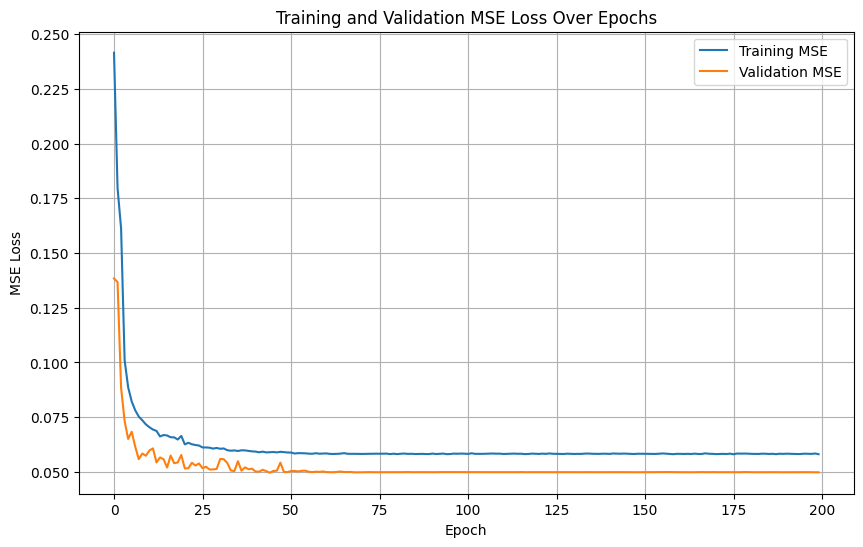

In [9]:
# Cell 8: Training Loop

best_val_mse = float('inf')
best_val_rmse = float('inf')
best_val_mae = float('inf')

train_mse_history = []
val_mse_history = []

if not train_loader or not val_loader:
    print("Skipping training as train_loader or val_loader is not available.")
else:
    for epoch in range(EPOCHS):
        model.train()
        epoch_train_mse_loss = 0
        epoch_train_mae_loss = 0

        # Using tqdm for progress bar in Colab
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]", unit="batch")
        for batch_features, batch_targets in train_pbar:
            batch_features, batch_targets = batch_features.to(DEVICE), batch_targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(batch_features) # Shape: (Batch, PredHorizon)

            # Ensure targets are (Batch, PredHorizon) for loss calculation
            if batch_targets.ndim == 3 and batch_targets.shape[-1] == 1: # (B, Horizon, 1)
                batch_targets_squeezed = batch_targets.squeeze(-1)
            elif batch_targets.ndim == 2: # (B, Horizon)
                batch_targets_squeezed = batch_targets
            else:
                raise ValueError(f"Unexpected target shape: {batch_targets.shape}")

            loss_mse = criterion(outputs, batch_targets_squeezed)
            loss_mae = nn.L1Loss()(outputs, batch_targets_squeezed)

            loss_mse.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()

            epoch_train_mse_loss += loss_mse.item()
            epoch_train_mae_loss += loss_mae.item()
            train_pbar.set_postfix(MSE=loss_mse.item(), MAE=loss_mae.item())

        avg_epoch_train_mse = epoch_train_mse_loss / len(train_loader)
        avg_epoch_train_rmse = calculate_rmse(avg_epoch_train_mse)
        avg_epoch_train_mae = epoch_train_mae_loss / len(train_loader)
        train_mse_history.append(avg_epoch_train_mse)

        # Validation
        model.eval()
        epoch_val_mse_loss = 0
        epoch_val_mae_loss = 0

        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]", unit="batch")
        with torch.no_grad():
            for batch_features, batch_targets in val_pbar:
                batch_features, batch_targets = batch_features.to(DEVICE), batch_targets.to(DEVICE)
                outputs = model(batch_features)

                if batch_targets.ndim == 3 and batch_targets.shape[-1] == 1:
                    batch_targets_squeezed = batch_targets.squeeze(-1)
                else:
                    batch_targets_squeezed = batch_targets

                loss_mse = criterion(outputs, batch_targets_squeezed)
                loss_mae = nn.L1Loss()(outputs, batch_targets_squeezed)
                epoch_val_mse_loss += loss_mse.item()
                epoch_val_mae_loss += loss_mae.item()
                val_pbar.set_postfix(MSE=loss_mse.item(), MAE=loss_mae.item())

        avg_epoch_val_mse = epoch_val_mse_loss / len(val_loader)
        avg_epoch_val_rmse = calculate_rmse(avg_epoch_val_mse)
        avg_epoch_val_mae = epoch_val_mae_loss / len(val_loader)
        val_mse_history.append(avg_epoch_val_mse)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:"
              f"\n  LR: {current_lr:.6f}"
              f"\n  Train MSE: {avg_epoch_train_mse:.6f}, RMSE: {avg_epoch_train_rmse:.6f}, MAE: {avg_epoch_train_mae:.6f}"
              f"\n  Val   MSE: {avg_epoch_val_mse:.6f}, RMSE: {avg_epoch_val_rmse:.6f}, MAE: {avg_epoch_val_mae:.6f}")

        scheduler.step(avg_epoch_val_mse)

        if avg_epoch_val_mse < best_val_mse:
            best_val_mse = avg_epoch_val_mse
            best_val_rmse = avg_epoch_val_rmse
            best_val_mae = avg_epoch_val_mae
            torch.save(model.state_dict(), 'best_msmvan_colab_model.pth')
            print(f"  >>> New best validation MSE: {best_val_mse:.6f}. Model saved. <<<")
        print("-" * 50)

print("\n--- Training Finished ---")
print(f"Best Validation MSE: {best_val_mse:.6f}")
print(f"Best Validation RMSE: {best_val_rmse:.6f}")
print(f"Best Validation MAE: {best_val_mae:.6f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_mse_history, label='Training MSE')
plt.plot(val_mse_history, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("msmvan_training_validation_loss.png")
plt.show()


--- Predicted Solar Radiation for Next 24 Hours (5-min intervals) ---
     Time_Step (5-min)  Predicted_Solar_Radiation
0                    1                   2.702833
1                    2                   3.898280
2                    3                   3.772861
3                    4                   5.044609
4                    5                   5.063971
..                 ...                        ...
283                284                  18.042549
284                285                  17.120880
285                286                  17.713692
286                287                  18.610086
287                288                  18.620913

[288 rows x 2 columns]

Predicted 24h data saved to 'predicted_24h_solar_radiation.csv'

--- Illustrative: Validation Loss for Various Window Sizes ---
Illustrative Val MSE for window size 24: 0.0661 (Dummy value)
Illustrative Val MSE for window size 48: 0.0579 (Dummy value)
Illustrative Val MSE for window size 96: 0.0579 (Dum

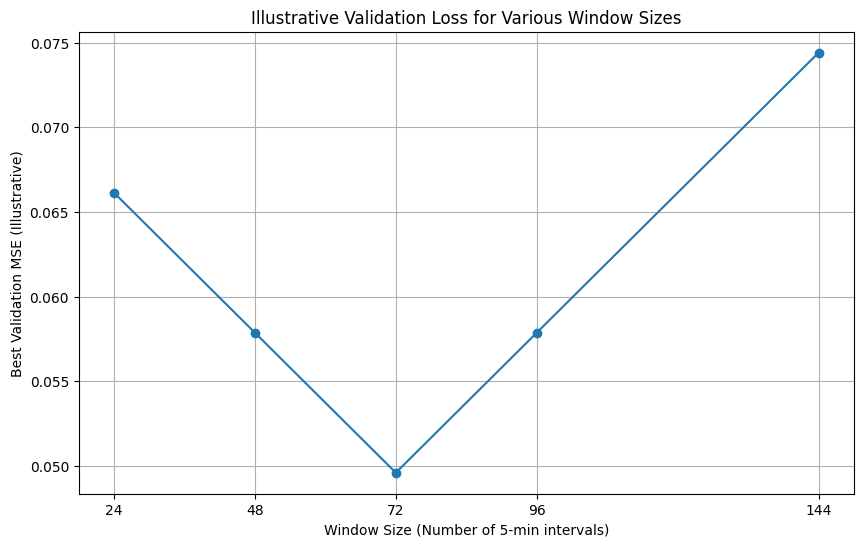

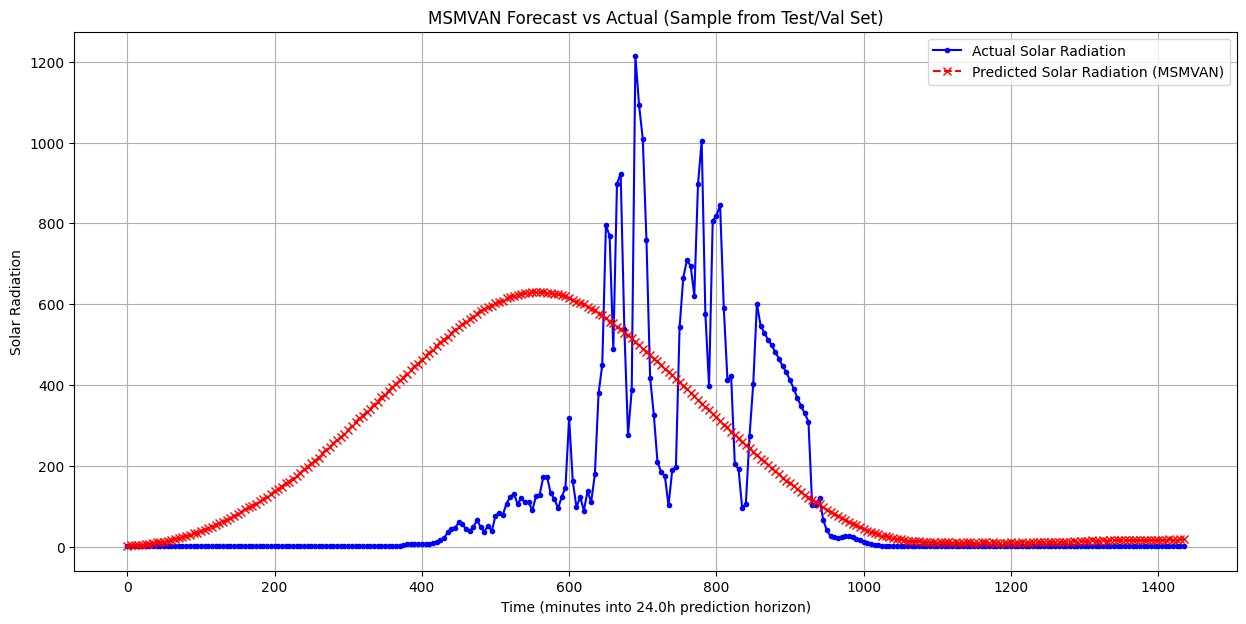

In [10]:
# Cell 9: Prediction for Next 24 Hours and Evaluation Plots

# Load the best model
model.load_state_dict(torch.load('best_msmvan_colab_model.pth'))
model.eval()

# --- Prediction for next 24 hours ---
# Take the last sequence from the original (scaled) data to predict
last_sequence_scaled = data_scaled[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1) # (1, SeqLen, 1)
last_sequence_tensor = torch.tensor(last_sequence_scaled, dtype=torch.float32).to(DEVICE)

with torch.no_grad():
    predicted_scaled_24h = model(last_sequence_tensor).cpu().numpy().flatten() # (PredHorizon,)

# Inverse transform the prediction
predicted_actual_24h = scaler.inverse_transform(predicted_scaled_24h.reshape(-1, 1)).flatten()

print("\n--- Predicted Solar Radiation for Next 24 Hours (5-min intervals) ---")
predicted_df = pd.DataFrame({'Time_Step (5-min)': range(1, PREDICTION_HORIZON + 1),
                             'Predicted_Solar_Radiation': predicted_actual_24h})
print(predicted_df)
predicted_df.to_csv("predicted_24h_solar_radiation.csv", index=False)
print("\nPredicted 24h data saved to 'predicted_24h_solar_radiation.csv'")


# --- Validation Loss for Various Window Sizes (Illustrative as in paper) ---
print("\n--- Illustrative: Validation Loss for Various Window Sizes ---")
# This part is complex as it ideally requires re-training for each window size.
# We'll create a conceptual plot based on the current model's performance for its window size.
window_sizes_to_test = [24, 48, SEQ_LENGTH, 96, 144] # e.g., 2h, 4h, current, 8h, 12h
val_losses_for_windows = {}

for ws in window_sizes_to_test:
    if ws == SEQ_LENGTH:
         val_losses_for_windows[ws] = best_val_mse if best_val_mse != float('inf') else (val_mse_history[-1] if val_mse_history else 0.1)
    else:
        # For other window sizes, we'd typically re-train.
        # Here, we'll use a placeholder value for illustration.
        # A more realistic dummy would be higher loss for very small/large windows.
        base_loss = best_val_mse if best_val_mse != float('inf') else 0.1
        deviation = abs(ws - SEQ_LENGTH) / SEQ_LENGTH # Normalized deviation
        val_losses_for_windows[ws] = base_loss * (1 + deviation * 0.5) # Dummy loss
        print(f"Illustrative Val MSE for window size {ws}: {val_losses_for_windows[ws]:.4f} (Dummy value)")


if val_losses_for_windows:
    plt.figure(figsize=(10, 6))
    sorted_windows = sorted(val_losses_for_windows.keys())
    sorted_losses = [val_losses_for_windows[w] for w in sorted_windows]
    plt.plot(sorted_windows, sorted_losses, marker='o', linestyle='-')
    plt.xlabel("Window Size (Number of 5-min intervals)")
    plt.ylabel("Best Validation MSE (Illustrative)")
    plt.title("Illustrative Validation Loss for Various Window Sizes")
    plt.grid(True)
    plt.xticks(window_sizes_to_test)
    plt.savefig("msmvan_val_loss_window_sizes_colab.png")
    plt.show()


# --- Plot Proposed Model Forecast vs Actual (on a segment of test/val data) ---
# Use a segment of test_loader or val_loader for this plot
plot_loader = test_loader if test_loader and len(test_loader) > 0 else (val_loader if val_loader and len(val_loader) > 0 else None)

if plot_loader:
    sample_features, sample_targets_scaled = next(iter(plot_loader))
    sample_features, sample_targets_scaled = sample_features.to(DEVICE), sample_targets_scaled.to(DEVICE)

    with torch.no_grad():
        sample_predictions_scaled = model(sample_features)

    # Select first sample from batch for plotting
    actual_plot_scaled = sample_targets_scaled[0].cpu().numpy().flatten()
    predicted_plot_scaled = sample_predictions_scaled[0].cpu().numpy().flatten()

    # Inverse transform
    actual_plot_inv = scaler.inverse_transform(actual_plot_scaled.reshape(-1, 1)).flatten()
    predicted_plot_inv = scaler.inverse_transform(predicted_plot_scaled.reshape(-1, 1)).flatten()

    plt.figure(figsize=(15, 7))
    time_steps_plot = np.arange(len(actual_plot_inv)) * 5 # Time in minutes
    plt.plot(time_steps_plot, actual_plot_inv, label='Actual Solar Radiation', color='blue', marker='.')
    plt.plot(time_steps_plot, predicted_plot_inv, label='Predicted Solar Radiation (MSMVAN)', color='red', linestyle='--', marker='x')
    plt.xlabel(f"Time (minutes into {PREDICTION_HORIZON*5/60:.1f}h prediction horizon)")
    plt.ylabel("Solar Radiation")
    plt.title("MSMVAN Forecast vs Actual (Sample from Test/Val Set)")
    plt.legend()
    plt.grid(True)
    plt.savefig("msmvan_forecast_vs_actual_colab.png")
    plt.show()
else:
    print("Plot loader (test or val) is empty, cannot plot forecast vs actual.")

In [11]:
# Cell 10: RL Agent and Environment (Simplified)
import random

# --- Simplified RL Configuration ---
# (These are very basic for illustration)
RL_LEARNING_RATE = 0.1
RL_DISCOUNT_FACTOR = 0.9 # Gamma
RL_EPSILON = 0.1 # For epsilon-greedy exploration
POSSIBLE_SEQ_LENGTHS = [24, 48, SEQ_LENGTH, 96, 144] # SEQ_LENGTH is from MSMVAN config
NUM_RL_EPISODES = 100 # Very few for quick demo
NUM_RL_STEPS_PER_EPISODE = 20 # How many times the agent makes a decision in an episode

# --- Q-Table (State: simplified, Action: index of SEQ_LENGTH) ---
# For simplicity, let's define a very coarse state.
# State: 0 for low recent error, 1 for high recent error (dummy concept)
# This state representation is highly insufficient for a real problem.
num_states_rl = 2
num_actions_rl = len(POSSIBLE_SEQ_LENGTHS)
q_table = np.zeros((num_states_rl, num_actions_rl))

# --- RL Helper Functions ---
def get_rl_state(recent_msmvan_error):
    """Simplistic function to get a state for RL."""
    # This is a placeholder. A real state would be more complex.
    # For example, if recent error is above a threshold, state = 1 (high error), else 0 (low error)
    threshold = 0.05 # Dummy threshold for scaled MSE
    if recent_msmvan_error > threshold:
        return 1
    else:
        return 0

def choose_rl_action(state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(num_actions_rl))  # Explore
    else:
        return np.argmax(q_table[state, :])  # Exploit

def simulate_msmvan_performance(chosen_seq_len_val, input_data_batch, target_data_batch, model_msmvan, scaler_msmvan, criterion_msmvan, device_msmvan):
    """
    Simulates running MSMVAN with a chosen seq_len and getting a reward (negative error).
    This is the most complex part to integrate realistically.
    For this demo, we'll need to dynamically create a sequence from input_data_batch.
    """
    model_msmvan.eval() # Ensure model is in eval mode

    # We need to re-create features and targets for the chosen_seq_len_val
    # This requires access to a longer history than just input_data_batch if chosen_seq_len_val > input_data_batch.shape[1]
    # For simplicity, let's assume input_data_batch is a segment of the original scaled data
    # and we can form a sequence from it.

    # This simulation is tricky. A proper way would be to have a pool of data
    # and dynamically create an input sequence of chosen_seq_len_val.
    # For this conceptual demo, let's assume input_data_batch IS the sequence of the chosen_seq_len_val
    # and we just run inference. This is a BIG simplification.

    # If the batch_features passed to this function is already of chosen_seq_len_val
    if input_data_batch.shape[1] != chosen_seq_len_val:
        # This part needs careful handling: either resample/truncate input_data_batch
        # or acknowledge this simulation needs a more robust data pipeline for dynamic seq_len
        # print(f"Warning: Simulating with seq_len {chosen_seq_len_val}, but batch has seq_len {input_data_batch.shape[1]}")
        # For now, let's return a dummy error if seq_len doesn't match to avoid crashing
        # In a real system, you'd prepare input_data_batch to match chosen_seq_len_val.
        # For this demo, we will just use the FIRST sample of the test_loader (which has fixed SEQ_LENGTH)
        # and conceptually "pretend" we used the chosen_seq_len_val. The MSMVAN model itself
        # is fixed to the original SEQ_LENGTH it was trained with.
        # A true dynamic seq_len would require a model that can handle variable input lengths
        # or multiple pre-trained models.
        pass # We'll use the fixed model and evaluate, reward will be somewhat artificial.


    with torch.no_grad():
        outputs = model_msmvan(input_data_batch.to(device_msmvan)) # MSMVAN trained with original SEQ_LENGTH

        if target_data_batch.ndim == 3 and target_data_batch.shape[-1] == 1:
            target_data_batch_squeezed = target_data_batch.squeeze(-1)
        else:
            target_data_batch_squeezed = target_data_batch

        loss_mse = criterion_msmvan(outputs, target_data_batch_squeezed.to(device_msmvan))

    # Reward is negative MSE. Higher reward is better.
    # Add a small penalty if the chosen_seq_len_val is very different from the model's optimal
    # This is highly artificial for this demo.
    ideal_seq_len_for_model = model_msmvan.seq_len # Get the seq_len model was trained with
    penalty = abs(chosen_seq_len_val - ideal_seq_len_for_model) / ideal_seq_len_for_model * 0.01 # Small penalty

    reward = -loss_mse.item() - penalty
    return reward, loss_mse.item()


print("Simplified RL components defined.")

Simplified RL components defined.



--- Starting Simplified RL Training (Conceptual) ---
RL Episode 10/100, Avg Reward: -0.0853, Current Epsilon: 0.09
RL Episode 20/100, Avg Reward: -0.0857, Current Epsilon: 0.08
RL Episode 30/100, Avg Reward: -0.0855, Current Epsilon: 0.07
RL Episode 40/100, Avg Reward: -0.0853, Current Epsilon: 0.07
RL Episode 50/100, Avg Reward: -0.0847, Current Epsilon: 0.06
RL Episode 60/100, Avg Reward: -0.0845, Current Epsilon: 0.06
RL Episode 70/100, Avg Reward: -0.0840, Current Epsilon: 0.05
RL Episode 80/100, Avg Reward: -0.0822, Current Epsilon: 0.05
RL Episode 90/100, Avg Reward: -0.0815, Current Epsilon: 0.04
RL Episode 100/100, Avg Reward: -0.0818, Current Epsilon: 0.04
--- Simplified RL Training Finished ---
Learned Q-Table (State x Action):
[[ 0.          0.          0.          0.          0.        ]
 [-0.81420828 -0.81182707 -0.8116107  -0.8119152  -0.81230335]]


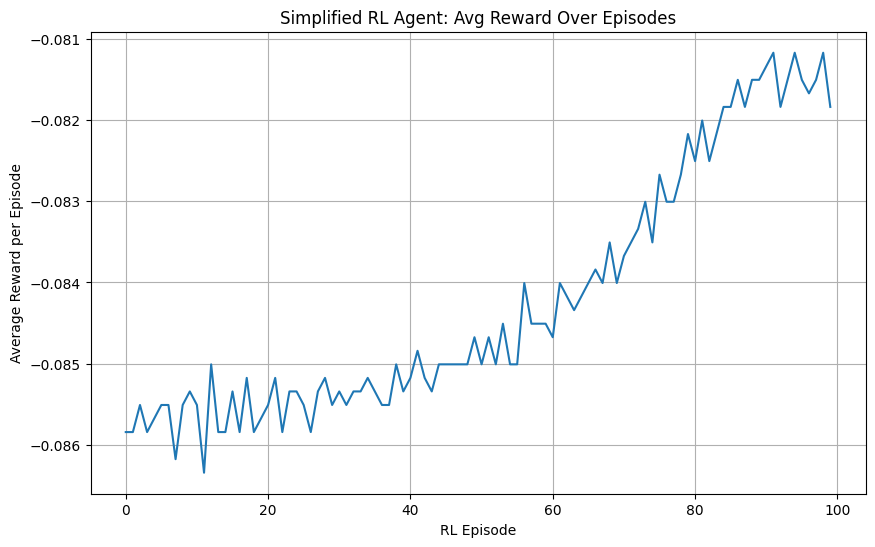

RL suggests Seq Length for 'low error' state: 24
RL suggests Seq Length for 'high error' state: 72


In [12]:
# Cell 11: Simplified RL Training Loop (Conceptual)

# Load the pre-trained MSMVAN model
msmvan_rl_model = MSMVAN_Univariate(
    input_size=1, hidden_size_lstm=HIDDEN_SIZE_LSTM, lstm_layers=2,
    ffc_out_channels_total=FDCNN_OUT_CHANNELS, attention_units=ATTENTION_UNITS,
    pred_horizon=PREDICTION_HORIZON, seq_len=SEQ_LENGTH, # Original SEQ_LENGTH
    dropout_rate=DROPOUT_RATE
).to(DEVICE)
msmvan_rl_model.load_state_dict(torch.load('best_msmvan_colab_model.pth'))
msmvan_rl_model.eval() # Set to evaluation mode

# Use criterion from MSMVAN training
msmvan_criterion = nn.MSELoss()

# We need some data to simulate MSMVAN performance. Use test_loader.
if not test_loader:
    print("RL Demo: Test loader is empty. Cannot run RL simulation.")
else:
    rl_episode_rewards = []
    # Placeholder for recent MSMVAN error to determine RL state
    # In a real scenario, this would be updated based on actual MSMVAN performance
    current_simulated_msmvan_error = 0.1 # Initial dummy error

    print("\n--- Starting Simplified RL Training (Conceptual) ---")
    for episode in range(NUM_RL_EPISODES):
        current_rl_state = get_rl_state(current_simulated_msmvan_error)
        episode_reward_sum = 0

        for step in range(NUM_RL_STEPS_PER_EPISODE):
            action_idx = choose_rl_action(current_rl_state, RL_EPSILON)
            chosen_seq_length_value = POSSIBLE_SEQ_LENGTHS[action_idx]

            # Get a batch of data for MSMVAN simulation
            # The MSMVAN model is fixed to its trained SEQ_LENGTH.
            # The RL agent *chooses* a conceptual seq_length, and the reward function
            # *simulates* or *penalizes* based on this choice relative to the model's fixed nature.
            # This is a major simplification.
            try:
                # Get a fixed batch from test_loader (input will always have original SEQ_LENGTH)
                rl_batch_features, rl_batch_targets = next(iter(test_loader))
            except StopIteration: # Reset iterator if test_loader is exhausted
                test_loader_iter = iter(test_loader)
                rl_batch_features, rl_batch_targets = next(test_loader_iter)


            # Simulate environment step
            # The core challenge: msmvan_rl_model expects input of shape (Batch, SEQ_LENGTH, 1)
            # If chosen_seq_length_value is different, we can't directly feed it.
            # For this demo, we pass the standard batch, and the reward function might
            # artificially consider the chosen_seq_length_value.
            reward, msvan_mse_for_step = simulate_msmvan_performance(
                chosen_seq_length_value,
                rl_batch_features, # This batch has the original SEQ_LENGTH
                rl_batch_targets,
                msmvan_rl_model,
                scaler, # The global scaler object
                msmvan_criterion,
                DEVICE
            )
            episode_reward_sum += reward
            current_simulated_msmvan_error = msvan_mse_for_step # Update simulated error

            # Q-table update (simplified)
            # For a real problem, the next_state would be based on the outcome of using chosen_seq_length_value
            next_rl_state = get_rl_state(current_simulated_msmvan_error)
            old_q_value = q_table[current_rl_state, action_idx]
            next_max_q = np.max(q_table[next_rl_state, :])

            new_q_value = (1 - RL_LEARNING_RATE) * old_q_value + \
                          RL_LEARNING_RATE * (reward + RL_DISCOUNT_FACTOR * next_max_q)
            q_table[current_rl_state, action_idx] = new_q_value

            current_rl_state = next_rl_state

        rl_episode_rewards.append(episode_reward_sum / NUM_RL_STEPS_PER_EPISODE)
        if (episode + 1) % 10 == 0:
            print(f"RL Episode {episode+1}/{NUM_RL_EPISODES}, Avg Reward: {episode_reward_sum / NUM_RL_STEPS_PER_EPISODE:.4f}, Current Epsilon: {RL_EPSILON:.2f}")

        # Decay epsilon (simple decay)
        if RL_EPSILON > 0.01:
            RL_EPSILON *= 0.99

    print("--- Simplified RL Training Finished ---")
    print("Learned Q-Table (State x Action):")
    print(q_table)

    # Plot RL rewards
    plt.figure(figsize=(10, 6))
    plt.plot(rl_episode_rewards)
    plt.xlabel("RL Episode")
    plt.ylabel("Average Reward per Episode")
    plt.title("Simplified RL Agent: Avg Reward Over Episodes")
    plt.grid(True)
    plt.savefig("simplified_rl_rewards.png")
    plt.show()

    # Example: Get optimal action for a given state
    optimal_action_low_error_state = np.argmax(q_table[0, :])
    optimal_seq_len_low_error = POSSIBLE_SEQ_LENGTHS[optimal_action_low_error_state]
    print(f"RL suggests Seq Length for 'low error' state: {optimal_seq_len_low_error}")

    optimal_action_high_error_state = np.argmax(q_table[1, :])
    optimal_seq_len_high_error = POSSIBLE_SEQ_LENGTHS[optimal_action_high_error_state]
    print(f"RL suggests Seq Length for 'high error' state: {optimal_seq_len_high_error}")